# JCC2 Application-Section Rating Matrix

This notebook creates comprehensive tables and visualizations showing application ratings across different JCC2 sections.

**Legend:**
- **x**: Application is not applicable to this section
- **\***: Application is applicable but no data available
- **Number**: Average rating score (1-6 scale)
- **N/A**: User indicated "Not Applicable" for this question

In [1]:
import sys
import os

# Add the parent directory to the path
sys.path.insert(0, os.path.abspath('..'))

# Import the processor module
from jcc2_data_processor import create_processor

In [2]:
# Ensure required packages are installed using uv
# If running in a new environment, run:
# uv sync
# Or install specific packages:
# uv pip install great-tables pandas numpy matplotlib seaborn openpyxl

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Import great_tables for enhanced table generation
from great_tables import GT, md, html, loc, style
from great_tables.data import exibble

# Configure visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Define consistent color scheme
COLORS = {
    'primary': '#1f77b4',
    'secondary': '#ff7f0e',
    'tertiary': '#9467bd',
    'success': '#2ca02c',
    'danger': '#d62728',
    'warning': '#ff9800',
    'info': '#17a2b8',
    'gray': '#7f7f7f'
}

In [4]:
# Create output directory for all exports
output_dir = 'jcc2_matrix_analysis_output'
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory created: {output_dir}")
print(f"All charts, graphs, and tables will be saved to: {os.path.abspath(output_dir)}")

Output directory created: jcc2_matrix_analysis_output
All charts, graphs, and tables will be saved to: /home/nathanjgaul/Development/projects/form_manager/data_analysis/jcc2_matrix_analysis_output


In [5]:
# Load data files
data_files = {
  "DCDC": "/home/nathanjgaul/Development/projects/form_manager/data_analysis/data/real_world_data/DCDC UQ Combined_2025-07-30_pii_scrubbed.csv",
  "CNMF": "/home/nathanjgaul/Development/projects/form_manager/data_analysis/data/real_world_data/CNMF UQ Combined_2025-08-03_pii_scrubbed.csv",
  "COGUARD": "/home/nathanjgaul/Development/projects/form_manager/data_analysis/data/real_world_data/GOGUARD UQ Combined_2025-08-03_pii_scrubbed.csv",
#   "JCC2 OUE - Phase 1 - User Questionnaires": "/home/nathanjgaul/Development/projects/form_manager/data_analysis/data/real_world_data/DCDC_CNMF_GOGUARD UQ Combined_2025-08-03_pii_scrubbed.csv"
}

# Initialize processors and dataframes
processors = {}
dataframes = {}
for name, filepath in data_files.items():
    try:
        processors[name] = create_processor(filepath)
        dataframes[name] = processors[name].load_data()
        print(f"\n{name}:")
        print(f"  - Data loaded: {len(dataframes[name])} responses, {len(dataframes[name].columns)} fields")
        if 'user_information.date' in dataframes[name].columns:
            print(f"  - Date range: {dataframes[name]['user_information.date'].min()} to {dataframes[name]['user_information.date'].max()}")
    except Exception as e:
        print(f"\nError loading {name}: {e}")

2025-08-04 07:55:10,823 - INFO - Detected User Questionnaire format
2025-08-04 07:55:10,824 - INFO - Loading data from /home/nathanjgaul/Development/projects/form_manager/data_analysis/data/real_world_data/DCDC UQ Combined_2025-07-30_pii_scrubbed.csv
2025-08-04 07:55:10,834 - INFO - Parsing field schemas
2025-08-04 07:55:10,839 - INFO - Loaded 21 data rows with 667 columns
2025-08-04 07:55:10,839 - INFO - Found 28 sections and 6 system columns
2025-08-04 07:55:10,855 - INFO - Detected User Questionnaire format
2025-08-04 07:55:10,855 - INFO - Loading data from /home/nathanjgaul/Development/projects/form_manager/data_analysis/data/real_world_data/CNMF UQ Combined_2025-08-03_pii_scrubbed.csv
2025-08-04 07:55:10,864 - INFO - Parsing field schemas
2025-08-04 07:55:10,871 - INFO - Loaded 6 data rows with 667 columns
2025-08-04 07:55:10,871 - INFO - Found 28 sections and 6 system columns
2025-08-04 07:55:10,896 - INFO - Detected User Questionnaire format
2025-08-04 07:55:10,897 - INFO - Load


DCDC:
  - Data loaded: 21 responses, 667 fields
  - Date range: 2025-06-23 to 2025-06-25

CNMF:
  - Data loaded: 6 responses, 667 fields
  - Date range: 2025-06-26 to 2025-06-26

COGUARD:
  - Data loaded: 6 responses, 667 fields
  - Date range: 2025-06-30 to 2025-06-30


In [6]:
# Define the target sections as requested
target_sections = [
    'mop_1_1_1',
    'mos_1_1_2',
    'mop_1_1_3',
    'reporting_and_data_export',
    'mop_1_1_5',
    'mop_1_2_1',
    'mop_1_2_2',
    'mos_1_3_1',
    'mop_1_3_2',
    'mop_1_3_3',
    'mop_1_3_4',
    'mop_1_3_5',
    'mop_2_1_1',
    'mop_2_1_2',
    'mop_2_1_7',
    'mop_2_1_9',
    'mop_2_3_1',
    'mop_2_3_2',
    'mop_2_4_1',
    'mos_3_2_1',
    'mos_3_2_2',
    'mop_3_2_3'
]

# Define all applications - include variations that might appear in field names
all_applications = [
    'a2it', 'cad', 'codex', 'crucible', 'cyber9line', 'dispatch',
    'jcc2cyberops', 'jcc2readiness', 'madss', 'rally', 'redmap',
    'sigact', 'threathub', 'triage', 'unity'
]

# Also check for variations
app_variations = {
    'cyber9line': ['cyber9line', 'cyber_9line', 'cyber-9line'],
    'jcc2cyberops': ['jcc2cyberops', 'jcc2_cyberops', 'jcc2-cyberops', 'cyberops'],
    'jcc2readiness': ['jcc2readiness', 'jcc2_readiness', 'jcc2-readiness', 'readiness'],
    'threathub': ['threathub', 'threat_hub', 'threat-hub']
}

# Create a reverse mapping from variation to canonical app name
variation_to_app = {}
for canonical_app, variations in app_variations.items():
    for variation in variations:
        variation_to_app[variation] = canonical_app

# Add standard apps that don't have variations
for app in all_applications:
    if app not in app_variations:
        variation_to_app[app] = app

# Create a comprehensive list of all possible app identifiers to check
all_app_identifiers = list(variation_to_app.keys())

# Display names for applications (proper formatting)
app_display_names = {
    'a2it': 'A2IT',
    'cad': 'CAD',
    'codex': 'Codex',
    'crucible': 'Crucible',
    'cyber9line': 'Cyber 9-Line',
    'dispatch': 'Dispatch',
    'jcc2cyberops': 'JCC2 Cyber Ops',
    'jcc2readiness': 'JCC2 Readiness',
    'madss': 'MADSS',
    'rally': 'Rally',
    'redmap': 'REDMAP',
    'sigact': 'SigAct',
    'threathub': 'Threat Hub',
    'triage': 'Triage',
    'unity': 'Unity'
}

# Display names for sections
section_display_names = {
    'mop_1_1_1': 'MOP 1.1.1',
    'mos_1_1_2': 'MOS 1.1.2',
    'mop_1_1_3': 'MOP 1.1.3',
    'reporting_and_data_export': 'Reporting & Export',
    'mop_1_1_5': 'MOP 1.1.5',
    'mop_1_2_1': 'MOP 1.2.1',
    'mop_1_2_2': 'MOP 1.2.2',
    'mos_1_3_1': 'MOS 1.3.1',
    'mop_1_3_2': 'MOP 1.3.2',
    'mop_1_3_3': 'MOP 1.3.3',
    'mop_1_3_4': 'MOP 1.3.4',
    'mop_1_3_5': 'MOP 1.3.5',
    'mop_2_1_1': 'MOP 2.1.1',
    'mop_2_1_2': 'MOP 2.1.2',
    'mop_2_1_7': 'MOP 2.1.7',
    'mop_2_1_9': 'MOP 2.1.9',
    'mop_2_3_1': 'MOP 2.3.1',
    'mop_2_3_2': 'MOP 2.3.2',
    'mop_2_4_1': 'MOP 2.4.1',
    'mos_3_2_1': 'MOS 3.2.1',
    'mos_3_2_2': 'MOS 3.2.2',
    'mop_3_2_3': 'MOP 3.2.3'
}

In [7]:
# Helper function to extract app name from field
def get_app_from_field(field_name, section_prefix=""):
    """
    Extract app name from field, checking for various patterns and variations
    """
    # Remove section prefix if provided
    if section_prefix and field_name.startswith(section_prefix):
        field_without_section = field_name[len(section_prefix) :].lstrip(".")
    else:
        field_without_section = field_name

    # Check all apps and their variations
    for canonical_app in all_applications:
        # Get variations for this app (or just the app itself if no variations)
        variations = app_variations.get(canonical_app, [canonical_app])

        for variation in variations:
            # Check multiple patterns:
            # 1. Field ends with variation
            # 2. Field ends with _variation
            # 3. Field ends with -variation
            if (
                field_without_section.endswith(variation)
                or field_without_section.endswith(f"_{variation}")
                or field_without_section.endswith(f"-{variation}")
            ):
                return canonical_app

    return None



# Helper functions for data processing

In [8]:
# Define rating mappings
rating_map = {
    'Completely Ineffective': 1,
    'Moderately Ineffective': 2,
    'Slightly Ineffective': 3,
    'Slightly Effective': 4,
    'Moderately Effective': 5,
    'Completely Effective': 6
}

# Function to calculate average rating for a field
def calculate_field_rating(field_name, df):
    if field_name not in df.columns:
        return None, 0, 0
    
    # Determine which mapping to use
    mapping = rating_map
    
    # Get all values
    values = df[field_name]
    
    # Count N/A responses
    na_count = (values == 'NA').sum() + (values == 'N/A').sum() + (values == 'Not Applicable').sum()
    
    # Get valid ratings (not null and not N/A)
    valid_mask = values.notna() & ~values.isin(['NA', 'N/A', 'Not Applicable'])
    valid_values = values[valid_mask]
    
    if len(valid_values) == 0:
        return None, na_count, len(values) - values.isna().sum()
    
    # Map to numeric values
    numeric_values = valid_values.map(mapping).dropna()
    
    if len(numeric_values) == 0:
        return None, na_count, len(values) - values.isna().sum()
    
    return numeric_values.mean(), na_count, len(values) - values.isna().sum()

In [9]:
# Helper function to check for rating fields
def normalize_for_comparison(lst):
    """Convert list to set, treating all NaN types as equivalent"""
    result = set()
    for item in lst:
        if pd.isna(item):
            result.add('__NaN__')
        else:
            result.add(item)
    return result

# Define standard rating values
rating_values = [
    'Completely Ineffective',
    'Moderately Ineffective',
    'Slightly Ineffective',
    'Slightly Effective',
    'Moderately Effective',
    'Completely Effective',
    'Not Applicable',
    float('nan'),
    np.nan
]

normalized_rating_set = normalize_for_comparison(rating_values)

In [10]:
# Function to create rating matrix for a given dataset
def create_rating_matrix(df, processor, dataset_name="Dataset"):
    """Create a rating matrix for a specific dataset"""
    
    print(f"\nCreating matrix for: {dataset_name}")
    print("=" * 80)
    
    # First, analyze sections for this dataset
    section_field_analysis = {}
    
    for section in target_sections:
        if section in processor.sections:
            fields = processor.sections[section]
            field_analysis = {
                "total_fields": len(fields),
                "app_specific_fields": {},
                "overall_fields": [],
            }

            # Identify rating fields
            rating_fields = [
                field
                for field in fields
                if not df[field].apply(lambda x: isinstance(x, list)).any()
                and not normalize_for_comparison(df[field].unique()) - normalized_rating_set
            ]

            for field in rating_fields:
                app_found = False
                field_lower = field.lower()
                
                # Check for app-specific field
                detected_app = get_app_from_field(field, section_prefix=f"{section}")
                if detected_app:
                    if detected_app not in field_analysis["app_specific_fields"]:
                        field_analysis["app_specific_fields"][detected_app] = []
                    field_analysis["app_specific_fields"][detected_app].append(field)
                    app_found = True
                elif field == "mop_2_4_1.mission_progress_assessment":
                    detected_app = "jcc2cyberops"
                    if detected_app not in field_analysis["app_specific_fields"]:
                        field_analysis["app_specific_fields"][detected_app] = []
                    field_analysis["app_specific_fields"][detected_app].append(field)
                    app_found = True

                # If not app-specific, it's likely an overall field
                if not app_found:
                    if "overall" in field_lower:
                        field_analysis["overall_fields"].append(field)
                    else:
                        field_analysis["overall_fields"].append(field)

            section_field_analysis[section] = field_analysis
    
    # Create the rating matrix
    matrix_data = []
    row_labels = []

    # Process each application
    for app in all_applications:
        row_data = []
        row_labels.append(app_display_names.get(app, app))
        
        for section in target_sections:
            if section not in section_field_analysis:
                row_data.append('x')
                continue

            # Check if this app has fields in this section
            app_fields = section_field_analysis[section]['app_specific_fields'].get(app, [])
            
            if not app_fields:
                row_data.append('x')
            else:
                # Calculate average rating for all app-specific fields
                ratings = []
                total_responses = 0
                na_responses = 0
                
                for field in app_fields:
                    rating, na_count, total_count = calculate_field_rating(field, df)
                    if rating is not None:
                        ratings.append(rating)
                    total_responses += total_count
                    na_responses += na_count
                
                if ratings:
                    avg_rating = np.mean(ratings)
                    row_data.append(f"{avg_rating:.1f}")
                elif na_responses > 0 and na_responses == total_responses:
                    row_data.append('N/A')
                else:
                    row_data.append('*')
        
        matrix_data.append(row_data)

    # Add JCC2 Overall row
    overall_row = []
    row_labels.append('JCC2 Overall')

    for section in target_sections:
        if section not in section_field_analysis:
            overall_row.append('x')
            continue
        
        # Get overall fields for this section
        overall_fields = section_field_analysis[section]['overall_fields']
        
        if not overall_fields:
            overall_row.append('x')
        else:
            ratings = []
            total_responses = 0
            na_responses = 0
            
            for field in overall_fields:
                rating, na_count, total_count = calculate_field_rating(field, df)
                if rating is not None:
                    ratings.append(rating)
                total_responses += total_count
                na_responses += na_count
            
            if ratings:
                avg_rating = np.mean(ratings)
                overall_row.append(f"{avg_rating:.1f}")
            elif na_responses > 0 and na_responses == total_responses:
                overall_row.append('N/A')
            else:
                overall_row.append('*')

    matrix_data.append(overall_row)

    # Create DataFrame
    column_labels = [section_display_names.get(s, s) for s in target_sections]
    matrix_df = pd.DataFrame(matrix_data, index=row_labels, columns=column_labels)
    
    return matrix_df, matrix_data, row_labels, column_labels

# Matrix generation functions

In [11]:
# Generate matrices for all datasets
all_matrices = {}
all_matrix_data = {}

# Process each dataset
for dataset_name, df_data in dataframes.items():
    processor_obj = processors[dataset_name]
    
    matrix_df, matrix_data, row_labels, column_labels = create_rating_matrix(
        df_data, processor_obj, dataset_name
    )
    
    all_matrices[dataset_name] = matrix_df
    all_matrix_data[dataset_name] = {
        'matrix_data': matrix_data,
        'row_labels': row_labels,
        'column_labels': column_labels
    }
    
    # Display the matrix
    print(f"\n\nRating Matrix for {dataset_name}:")
    print("=" * 120)
    print(matrix_df)
    print("\n")


Creating matrix for: DCDC


Rating Matrix for DCDC:
               MOP 1.1.1 MOS 1.1.2 MOP 1.1.3 Reporting & Export MOP 1.1.5  \
A2IT                 4.6         x         x                4.0       4.3   
CAD                  N/A         x         x                1.0       N/A   
Codex                3.5         x         x                2.1       4.0   
Crucible             3.5         x         x                2.1       4.0   
Cyber 9-Line         3.5         x         x                2.1       4.0   
Dispatch             5.0         x         x                N/A       N/A   
JCC2 Cyber Ops       3.7         x         x                2.3       2.2   
JCC2 Readiness       4.0         x         x                4.3       4.2   
MADSS                3.8       3.2       3.0                3.3       2.2   
Rally                4.8       5.0         x                4.6       4.5   
REDMAP               4.0         x         x                3.9       3.0   
SigAct               4.

# Generate matrices for all datasets

In [12]:
# First, let's create the analysis data for application usage across datasets
# This will analyze which applications are used in each dataset

# Initialize tracking of application usage
app_usage_tracker = {}

# Analyze each dataset for application usage
for dataset_name, data in all_matrix_data.items():
    matrix_data = data['matrix_data']
    row_labels = data['row_labels']
    
    # Check each application (exclude JCC2 Overall)
    for i, app in enumerate(row_labels[:-1]):
        if app not in app_usage_tracker:
            app_usage_tracker[app] = {
                'datasets_using': [],
                'total_ratings': 0,
                'total_possible': 0
            }
        
        # Count ratings for this app
        row = matrix_data[i]
        has_data = False
        for val in row:
            if val not in ['x', '*', 'N/A']:
                try:
                    float(val)
                    has_data = True
                    app_usage_tracker[app]['total_ratings'] += 1
                except:
                    pass
            app_usage_tracker[app]['total_possible'] += 1
        
        # Track if this dataset uses this app
        if has_data:
            app_usage_tracker[app]['datasets_using'].append(dataset_name)

# Create analysis DataFrame
analysis_data = []
for app, usage_info in app_usage_tracker.items():
    analysis_data.append({
        'Application Section': app,
        'Usage Count': usage_info['total_ratings'],
        'Usage %': usage_info['total_ratings'] / usage_info['total_possible'] if usage_info['total_possible'] > 0 else 0,
        'Datasets Using': len(usage_info['datasets_using']),
        'Datasets List': ', '.join(usage_info['datasets_using'])
    })

analysis_df = pd.DataFrame(analysis_data)
analysis_df = analysis_df.sort_values('Usage Count', ascending=False)

# Create analysis parameters for the subtitle
datasets = list(dataframes.keys())
analysis_params = {
    'file_stems': [name.split(' - ')[-1] for name in datasets]
}

print("Application usage analysis completed.")
print(f"Total applications analyzed: {len(analysis_df)}")
print(f"Datasets included: {len(datasets)}")

# Now create the enhanced Application Section Priority Matrix with great_tables
application_priority_table = (
    GT(analysis_df, rowname_col="Application Section")
    .tab_header(
        title="JCC2 Application Section Priority Matrix",
        subtitle=f"Analysis of {len(datasets)} datasets from {', '.join(analysis_params['file_stems'])}"
    )
    .fmt_number(
        columns=["Usage Count", "Datasets Using"],
        decimals=0
    )
    .fmt_percent(
        columns=["Usage %"],
        decimals=1
    )
    # Clean up the styling - use only conditional formatting, not overlapping styles
    .tab_style(
        style=[style.text(weight="bold")],
        locations=loc.body(columns=["Usage Count", "Usage %", "Datasets Using"])
    )
    .tab_style(
        style=[style.fill(color="#dc3545")],  # Red for low usage
        locations=loc.body(
            columns=["Usage %"],
            rows=lambda df: df["Usage %"] < 0.3
        )
    )
    .tab_style(
        style=[style.fill(color="#ffc107")],  # Yellow for medium usage
        locations=loc.body(
            columns=["Usage %"],
            rows=lambda df: (df["Usage %"] >= 0.3) & (df["Usage %"] < 0.7)
        )
    )
    .tab_style(
        style=[style.fill(color="#28a745")],  # Green for high usage
        locations=loc.body(
            columns=["Usage %"],
            rows=lambda df: df["Usage %"] >= 0.7
        )
    )
    .tab_options(
        table_width="800px",  # Fixed width suitable for PowerPoint
        table_font_size="11px",  # Slightly smaller font for better fit
        heading_title_font_size="16px",
        heading_subtitle_font_size="12px",
        data_row_padding="8px",
        column_labels_padding="8px"
    )
)

# Display the table
application_priority_table

# Save as PNG with scale for better resolution
application_priority_table.save(f'{output_dir}/application_section_priority_matrix.png', scale=2)
print(f"Application section priority matrix saved to {output_dir}/application_section_priority_matrix.png")

Application usage analysis completed.
Total applications analyzed: 15
Datasets included: 3
Application section priority matrix saved to jcc2_matrix_analysis_output/application_section_priority_matrix.png



HEATMAP VISUALIZATIONS

Saved heatmap for DCDC to: jcc2_matrix_analysis_output/DCDC_heatmap.png


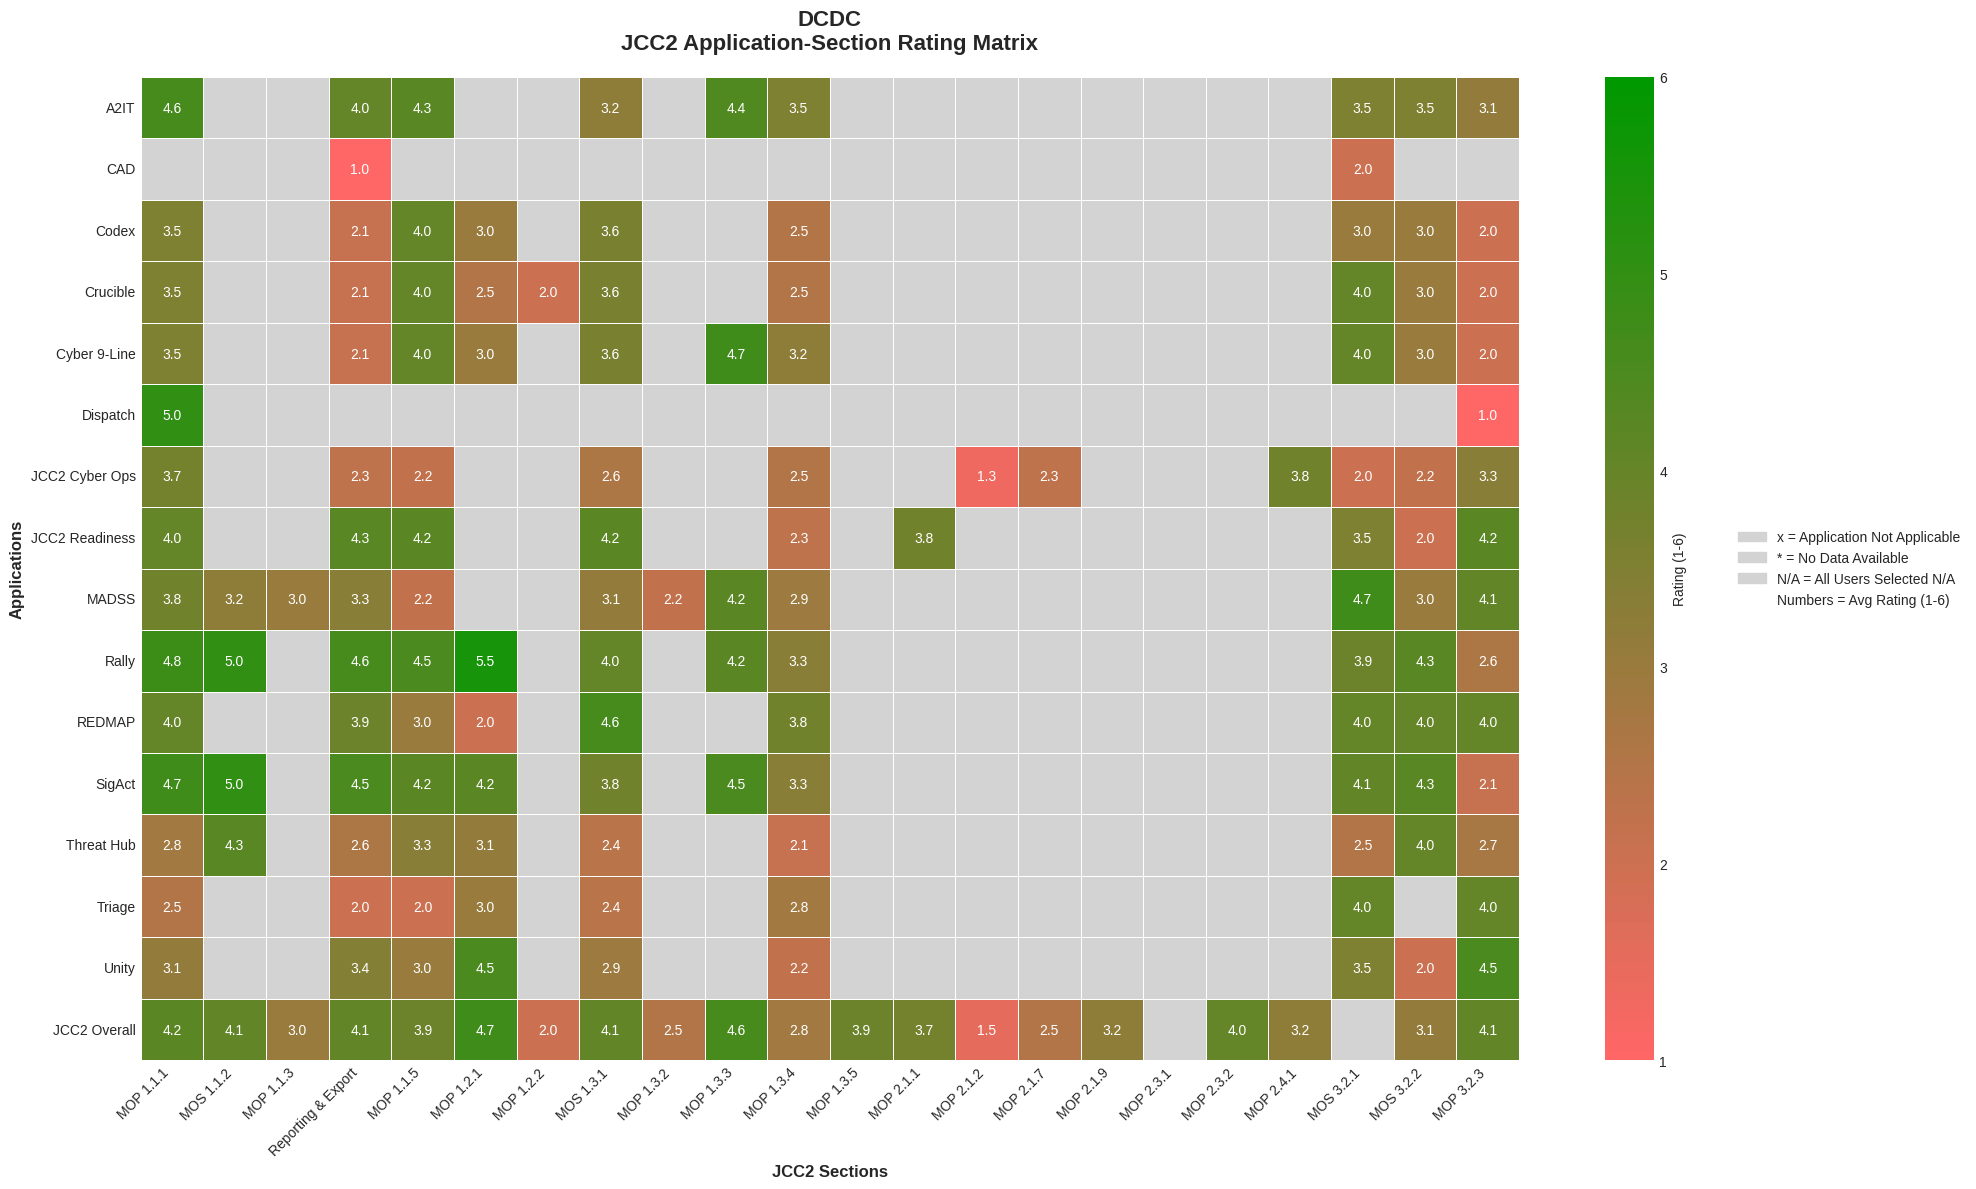


Saved heatmap for CNMF to: jcc2_matrix_analysis_output/CNMF_heatmap.png


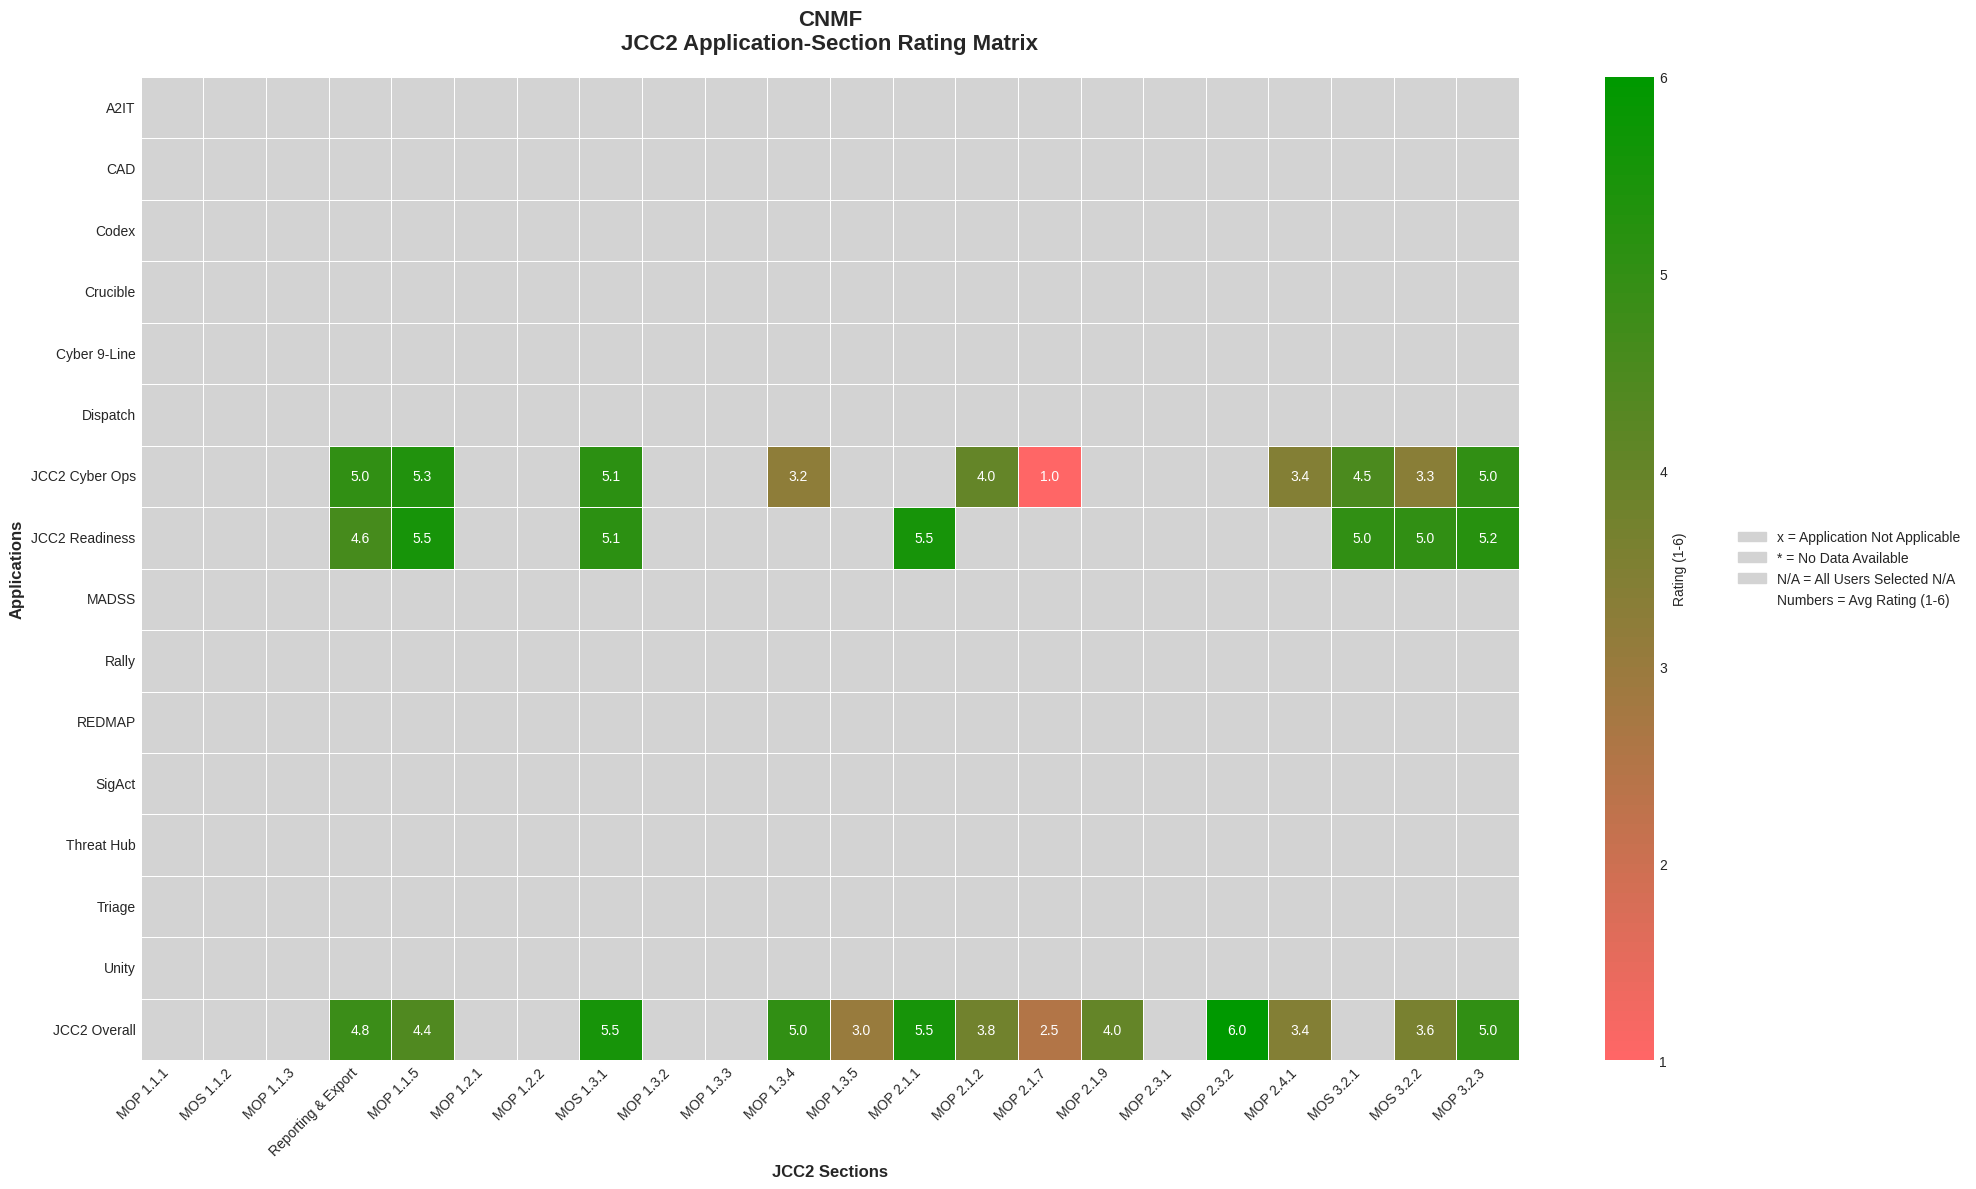


Saved heatmap for COGUARD to: jcc2_matrix_analysis_output/COGUARD_heatmap.png


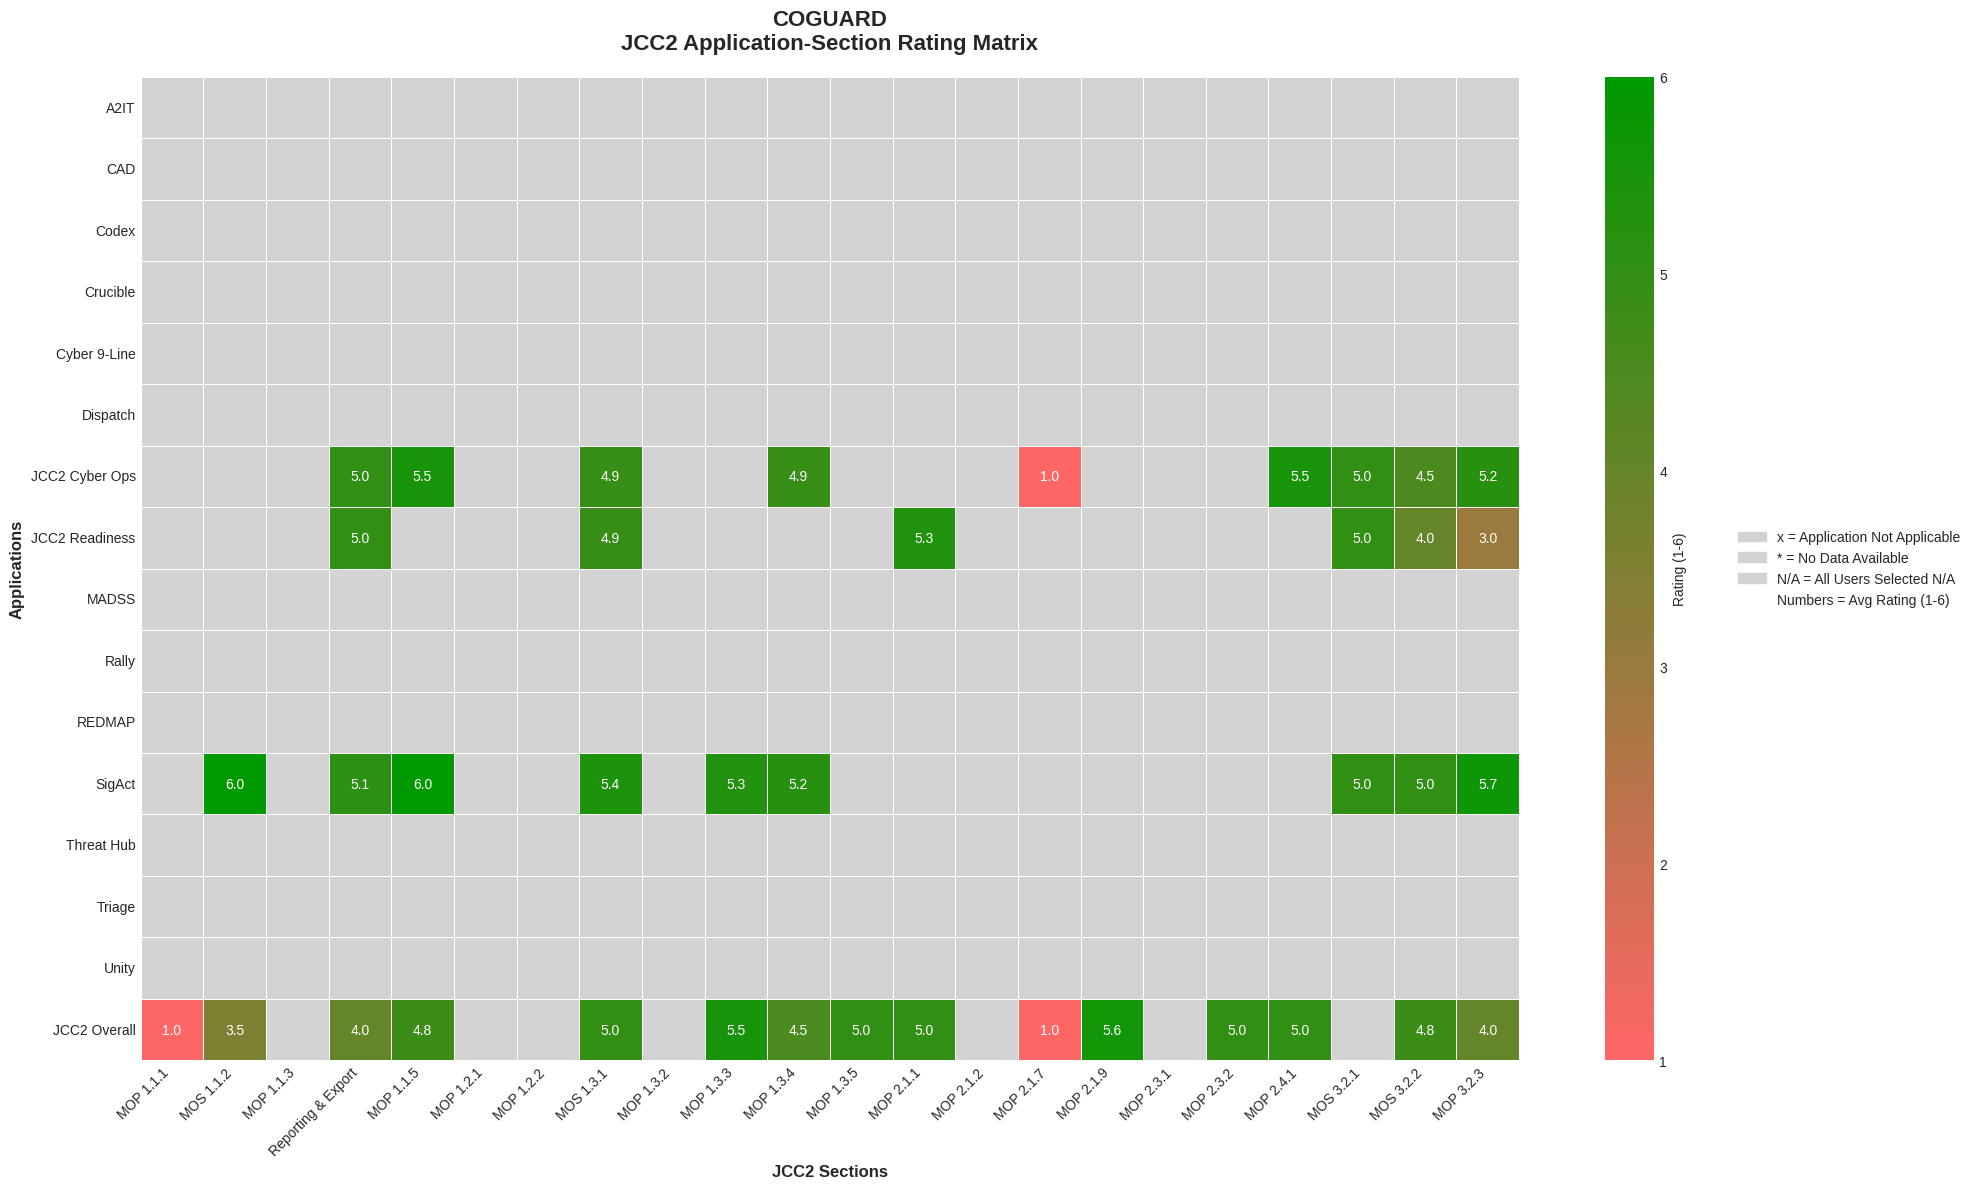

In [13]:
# Create individual heatmaps for each dataset
def create_dataset_heatmap(dataset_name, matrix_df, matrix_data, row_labels, column_labels):
    """Create a heatmap for a specific dataset"""
    
    # Convert matrix to numeric for visualization
    numeric_matrix = []
    annotation_matrix = []

    for row in matrix_data:
        numeric_row = []
        annot_row = []
        for val in row:
            if val == 'x':
                numeric_row.append(np.nan)  # Use NaN for grey cells
                annot_row.append('x')
            elif val == '*':
                numeric_row.append(np.nan)  # Use NaN for grey cells
                annot_row.append('*')
            elif val == 'N/A':
                numeric_row.append(np.nan)  # Use NaN for grey cells
                annot_row.append('N/A')
            else:
                try:
                    numeric_val = float(val)
                    numeric_row.append(numeric_val)
                    annot_row.append(val)  # Keep the original string format
                except:
                    numeric_row.append(np.nan)
                    annot_row.append('')
        numeric_matrix.append(numeric_row)
        annotation_matrix.append(annot_row)

    # Create figure
    fig, ax = plt.subplots(figsize=(20, 12))

    # Create custom colormap
    from matplotlib.colors import LinearSegmentedColormap
    import matplotlib.patches as mpatches

    # Define colors for the gradient (red to green)
    colors = ['#ff6666', '#009900']
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('rating', colors, N=n_bins)
    
    # Set the color for NaN values (masked cells) to grey
    cmap.set_bad(color='#d3d3d3')

    # Create the DataFrames
    numeric_df = pd.DataFrame(numeric_matrix, index=row_labels, columns=column_labels)
    annot_df = pd.DataFrame(annotation_matrix, index=row_labels, columns=column_labels)
    
    # Plot heatmap with custom annotations
    sns.heatmap(numeric_df, annot=annot_df, fmt='', 
                cmap=cmap, vmin=1, vmax=6, cbar_kws={'label': 'Rating (1-6)'}, 
                linewidths=0.5, ax=ax, annot_kws={'size': 10})

    # Customize the plot
    ax.set_title(f'{dataset_name}\nJCC2 Application-Section Rating Matrix', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('JCC2 Sections', fontsize=12, fontweight='bold')
    ax.set_ylabel('Applications', fontsize=12, fontweight='bold')

    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Add legend for special symbols
    legend_elements = [
        mpatches.Patch(color='#d3d3d3', label='x = Application Not Applicable'),
        mpatches.Patch(color='#d3d3d3', label='* = No Data Available'),
        mpatches.Patch(color='#d3d3d3', label='N/A = All Users Selected N/A'),
        mpatches.Patch(color='white', label='Numbers = Avg Rating (1-6)')
    ]
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.15, 0.5))

    plt.tight_layout()
    return fig

# Generate heatmaps for all datasets
print("\n" + "="*80)
print("HEATMAP VISUALIZATIONS")
print("="*80)

for dataset_name in all_matrices.keys():
    data = all_matrix_data[dataset_name]
    fig = create_dataset_heatmap(
        dataset_name, 
        all_matrices[dataset_name],
        data['matrix_data'],
        data['row_labels'],
        data['column_labels']
    )
    
    # Clean filename
    clean_name = dataset_name.replace(' - ', '_').replace(' ', '_').replace('/', '_')
    heatmap_filename = f"{output_dir}/{clean_name}_heatmap.png"
    
    # Save the figure
    fig.savefig(heatmap_filename, dpi=300, bbox_inches='tight')
    print(f"\nSaved heatmap for {dataset_name} to: {heatmap_filename}")
    
    # Display the figure
    plt.show()
    plt.close()

# Visualization functions


Generating Comparative Analysis...

Saved comparative analysis to: jcc2_matrix_analysis_output/comparative_analysis.png


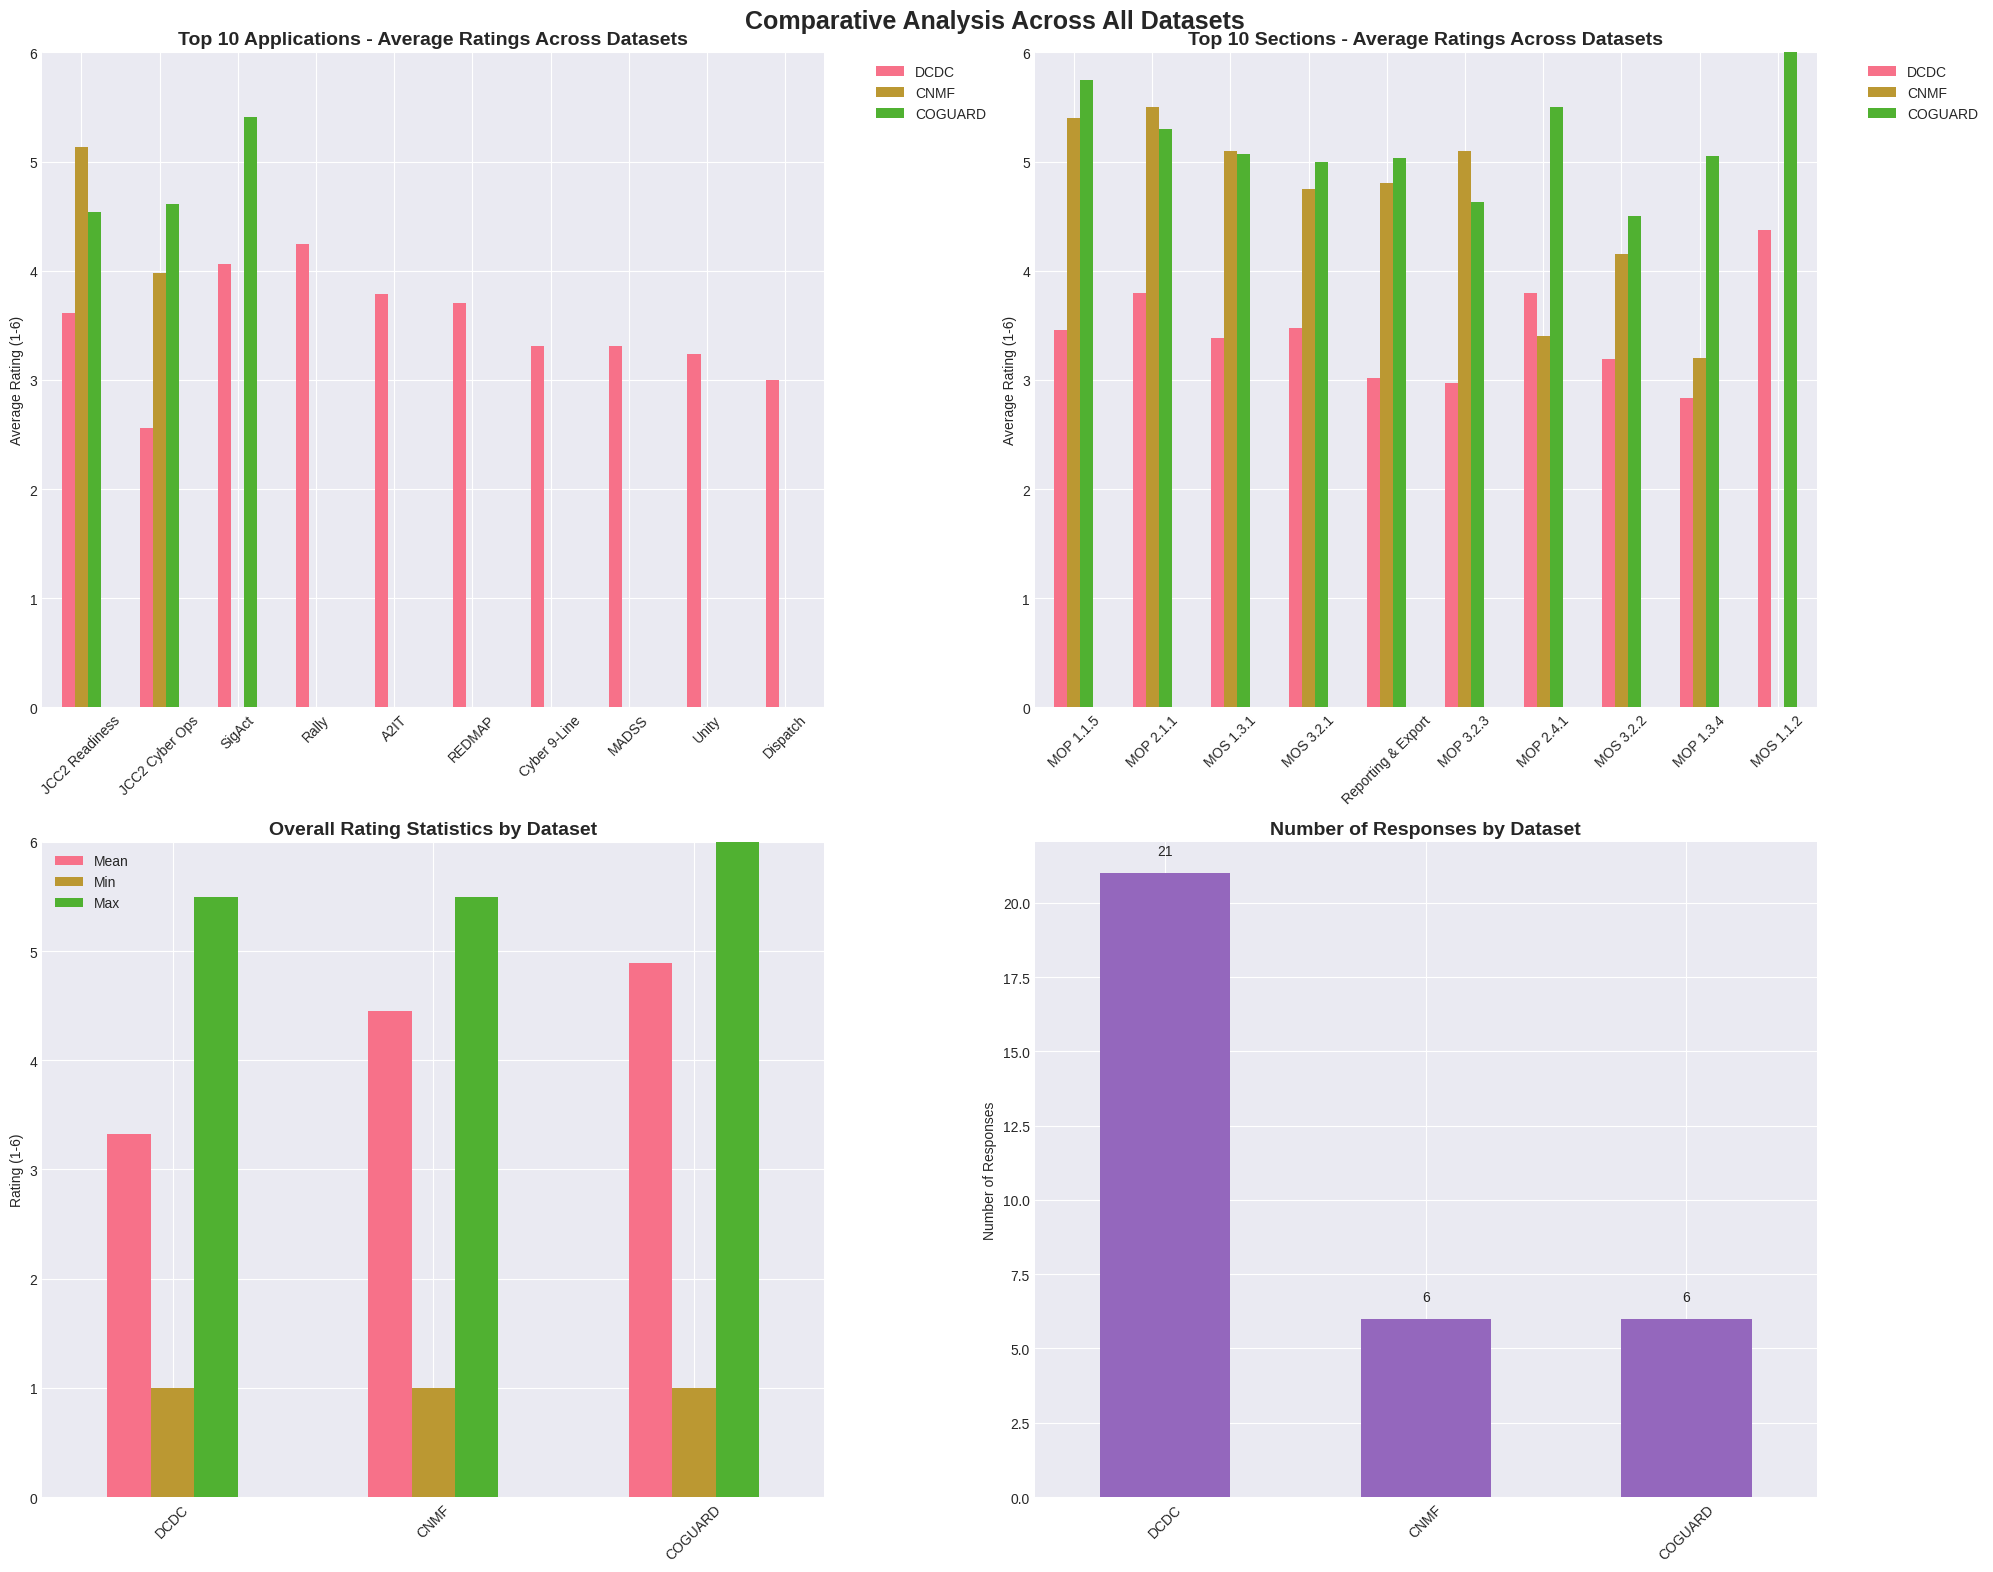



Application Ratings Comparison (Top 10):
JCC2 Readiness    4.42
JCC2 Cyber Ops    3.72
SigAct            3.16
Rally             1.42
A2IT              1.26
REDMAP            1.23
Cyber 9-Line      1.10
MADSS             1.10
Unity             1.08
Dispatch          1.00
dtype: float64


Section Ratings Comparison (Top 10):
MOP 1.1.5             4.87
MOP 2.1.1             4.87
MOS 1.3.1             4.52
MOS 3.2.1             4.41
Reporting & Export    4.28
MOP 3.2.3             4.23
MOP 2.4.1             4.23
MOS 3.2.2             3.95
MOP 1.3.4             3.70
MOS 1.1.2             3.46
dtype: float64


Overall Statistics by Dataset:
         Mean  Std Dev  Min  Max
DCDC     3.32     0.94  1.0  5.5
CNMF     4.45     1.13  1.0  5.5
COGUARD  4.89     1.01  1.0  6.0


In [14]:
# Create comparative visualizations across datasets
def create_comparative_analysis():
    """Create visualizations comparing ratings across all datasets"""
    
    # 1. Application comparison across datasets
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Comparative Analysis Across All Datasets', fontsize=18, fontweight='bold')
    
    # Calculate average ratings per application for each dataset
    app_ratings_by_dataset = {}
    
    for dataset_name, data in all_matrix_data.items():
        matrix_data = data['matrix_data']
        row_labels = data['row_labels']
        
        app_ratings = {}
        for i, app in enumerate(row_labels[:-1]):  # Exclude JCC2 Overall
            row = matrix_data[i]
            ratings = []
            for val in row:
                try:
                    rating = float(val)
                    ratings.append(rating)
                except:
                    pass
            
            if ratings:
                app_ratings[app] = np.mean(ratings)
        
        app_ratings_by_dataset[dataset_name] = app_ratings
    
    # Create dataframe for comparison
    comparison_df = pd.DataFrame(app_ratings_by_dataset)
    comparison_df = comparison_df.fillna(0)  # Fill missing values with 0
    
    # Plot 1: Bar chart comparing top applications
    ax1 = axes[0, 0]
    top_apps = comparison_df.mean(axis=1).nlargest(10).index
    comparison_df.loc[top_apps].plot(kind='bar', ax=ax1)
    ax1.set_title('Top 10 Applications - Average Ratings Across Datasets', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Average Rating (1-6)')
    ax1.set_ylim(0, 6)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: Section comparison across datasets
    ax2 = axes[0, 1]
    section_ratings_by_dataset = {}
    
    for dataset_name, data in all_matrix_data.items():
        matrix_data = data['matrix_data']
        column_labels = data['column_labels']
        
        section_ratings = {}
        for j, section in enumerate(column_labels):
            column_values = [matrix_data[i][j] for i in range(len(matrix_data)-1)]  # Exclude JCC2 Overall
            ratings = []
            for val in column_values:
                try:
                    rating = float(val)
                    ratings.append(rating)
                except:
                    pass
            
            if ratings:
                section_ratings[section] = np.mean(ratings)
        
        section_ratings_by_dataset[dataset_name] = section_ratings
    
    section_comparison_df = pd.DataFrame(section_ratings_by_dataset)
    section_comparison_df = section_comparison_df.fillna(0)
    
    # Select top sections
    top_sections = section_comparison_df.mean(axis=1).nlargest(10).index
    section_comparison_df.loc[top_sections].plot(kind='bar', ax=ax2)
    ax2.set_title('Top 10 Sections - Average Ratings Across Datasets', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Average Rating (1-6)')
    ax2.set_ylim(0, 6)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.tick_params(axis='x', rotation=45)
    
    # Plot 3: Overall statistics comparison
    ax3 = axes[1, 0]
    overall_stats = {}
    
    for dataset_name, data in all_matrix_data.items():
        matrix_data = data['matrix_data']
        all_ratings = []
        
        for row in matrix_data[:-1]:  # Exclude JCC2 Overall
            for val in row:
                try:
                    rating = float(val)
                    all_ratings.append(rating)
                except:
                    pass
        
        if all_ratings:
            overall_stats[dataset_name] = {
                'Mean': np.mean(all_ratings),
                'Std Dev': np.std(all_ratings),
                'Min': np.min(all_ratings),
                'Max': np.max(all_ratings)
            }
    
    stats_df = pd.DataFrame(overall_stats).T
    stats_df[['Mean', 'Min', 'Max']].plot(kind='bar', ax=ax3)
    ax3.set_title('Overall Rating Statistics by Dataset', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Rating (1-6)')
    ax3.set_ylim(0, 6)
    ax3.tick_params(axis='x', rotation=45)
    
    # Plot 4: Response count comparison
    ax4 = axes[1, 1]
    response_counts = {}
    
    for dataset_name in dataframes.keys():
        response_counts[dataset_name] = len(dataframes[dataset_name])
    
    pd.Series(response_counts).plot(kind='bar', ax=ax4, color=COLORS['tertiary'])
    ax4.set_title('Number of Responses by Dataset', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Number of Responses')
    ax4.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for i, (dataset, count) in enumerate(response_counts.items()):
        ax4.text(i, count + 0.5, str(count), ha='center', va='bottom')
    
    plt.tight_layout()
    
    # Save the figure
    comparative_filename = f"{output_dir}/comparative_analysis.png"
    fig.savefig(comparative_filename, dpi=300, bbox_inches='tight')
    print(f"\nSaved comparative analysis to: {comparative_filename}")
    
    # Display the figure
    plt.show()
    
    return comparison_df, section_comparison_df, stats_df

# Generate comparative analysis
print("\nGenerating Comparative Analysis...")
print("=" * 80)
app_comparison_df, section_comparison_df, stats_df = create_comparative_analysis()

# Display summary tables
print("\n\nApplication Ratings Comparison (Top 10):")
print(app_comparison_df.mean(axis=1).nlargest(10).round(2))

print("\n\nSection Ratings Comparison (Top 10):")
print(section_comparison_df.mean(axis=1).nlargest(10).round(2))

print("\n\nOverall Statistics by Dataset:")
print(stats_df.round(2))

# Comparative analysis across datasets

# Individual Dataset Average Rating Charts

In [15]:
def get_rating_styling(score):
    if score >= 5.0: 
        return ('#2ca02c', 'Excellent (5-6)')
    elif score >= 4.0:
        return ('#ff7f0e', 'Good (4-5)')
    elif score >= 3.0:
        return ('#ffcc00', 'Fair (3-4)')
    else:
        return ('#d62728', 'Poor (<3)')
    
from matplotlib.patches import Rectangle
def get_rating_legend_elements():
    """Return legend elements for rating categories"""
    return [
        Rectangle((0,0), 1, 1, fc='#2ca02c', label='Excellent (5-6)'),
        Rectangle((0,0), 1, 1, fc='#ff7f0e', label='Good (4-5)'),
        Rectangle((0,0), 1, 1, fc='#ffcc00', label='Fair (3-4)'),
        Rectangle((0,0), 1, 1, fc='#d62728', label='Poor (<3)')
    ]


INDIVIDUAL DATASET RATING CHARTS

Saved average ratings chart for DCDC to: jcc2_matrix_analysis_output/DCDC_average_ratings_chart.png


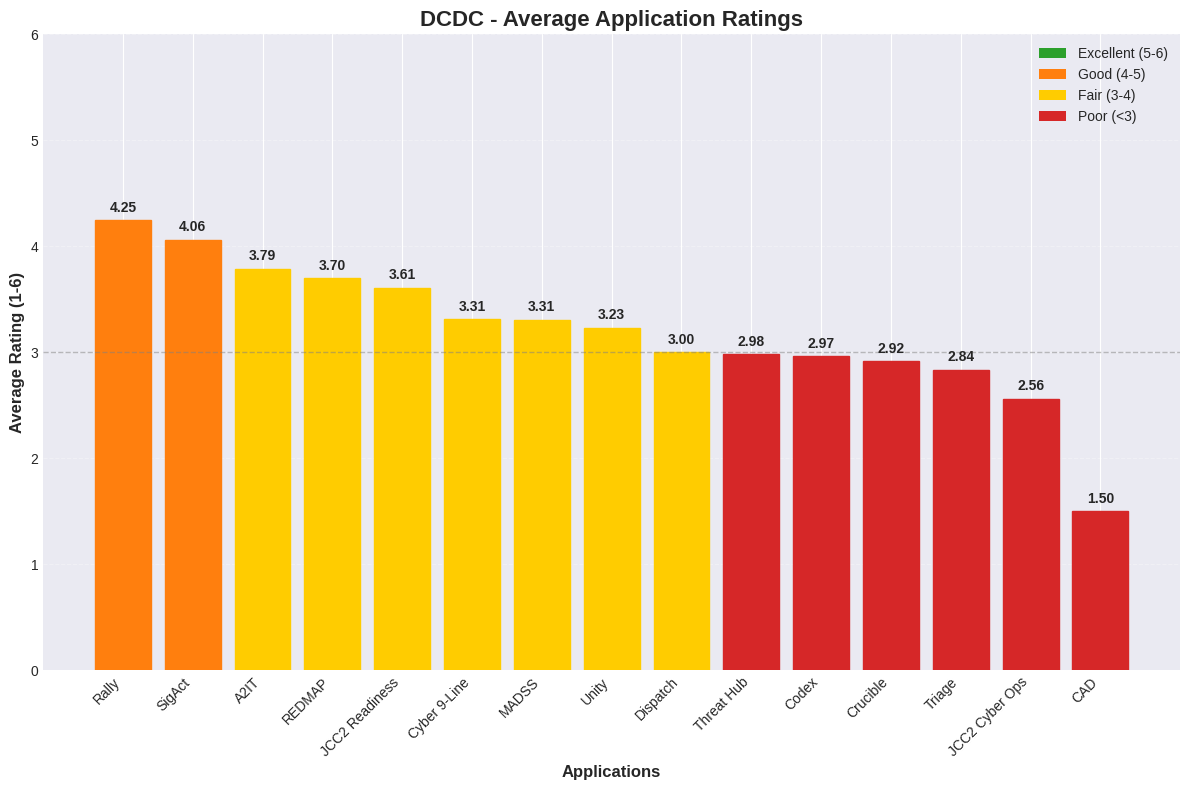


Summary for DCDC:
  - Total applications with data: 15
  - Highest rated: Rally (4.25)
  - Lowest rated: CAD (1.50)
  - Average across all apps: 3.20

Saved average ratings chart for CNMF to: jcc2_matrix_analysis_output/CNMF_average_ratings_chart.png


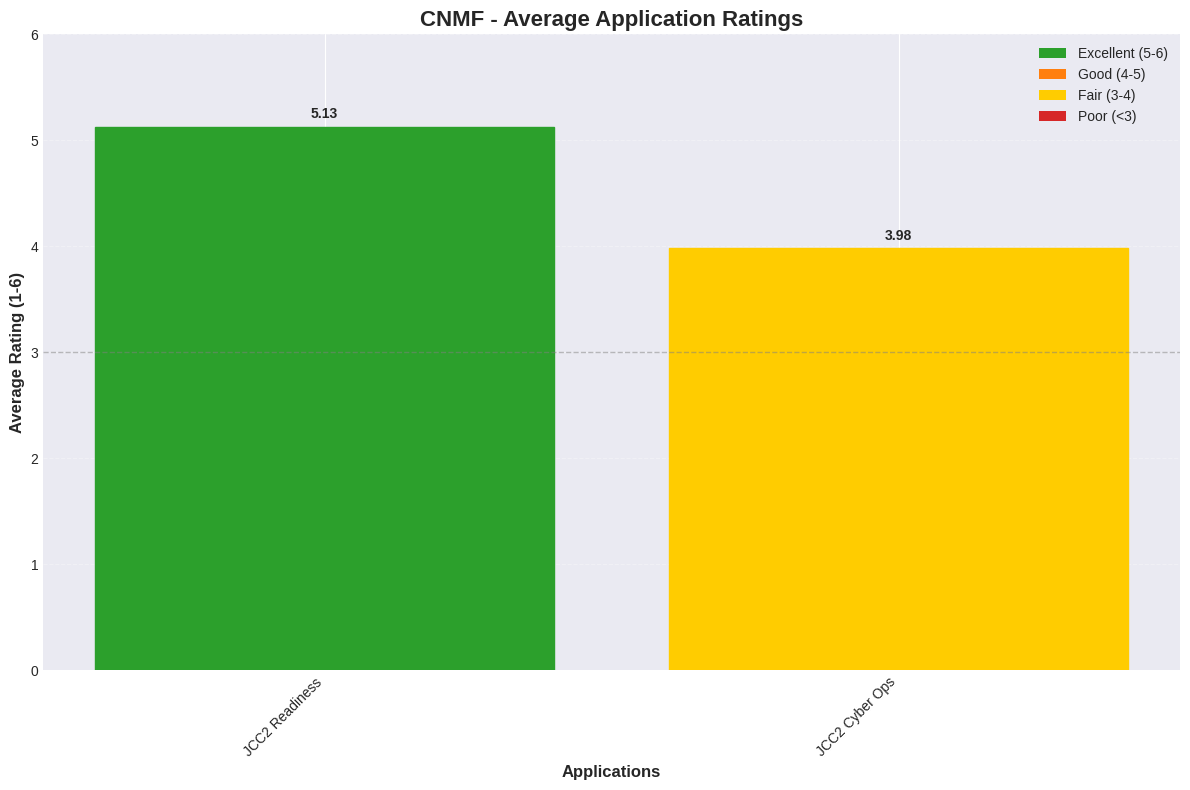


Summary for CNMF:
  - Total applications with data: 2
  - Highest rated: JCC2 Readiness (5.13)
  - Lowest rated: JCC2 Cyber Ops (3.98)
  - Average across all apps: 4.55

Saved average ratings chart for COGUARD to: jcc2_matrix_analysis_output/COGUARD_average_ratings_chart.png


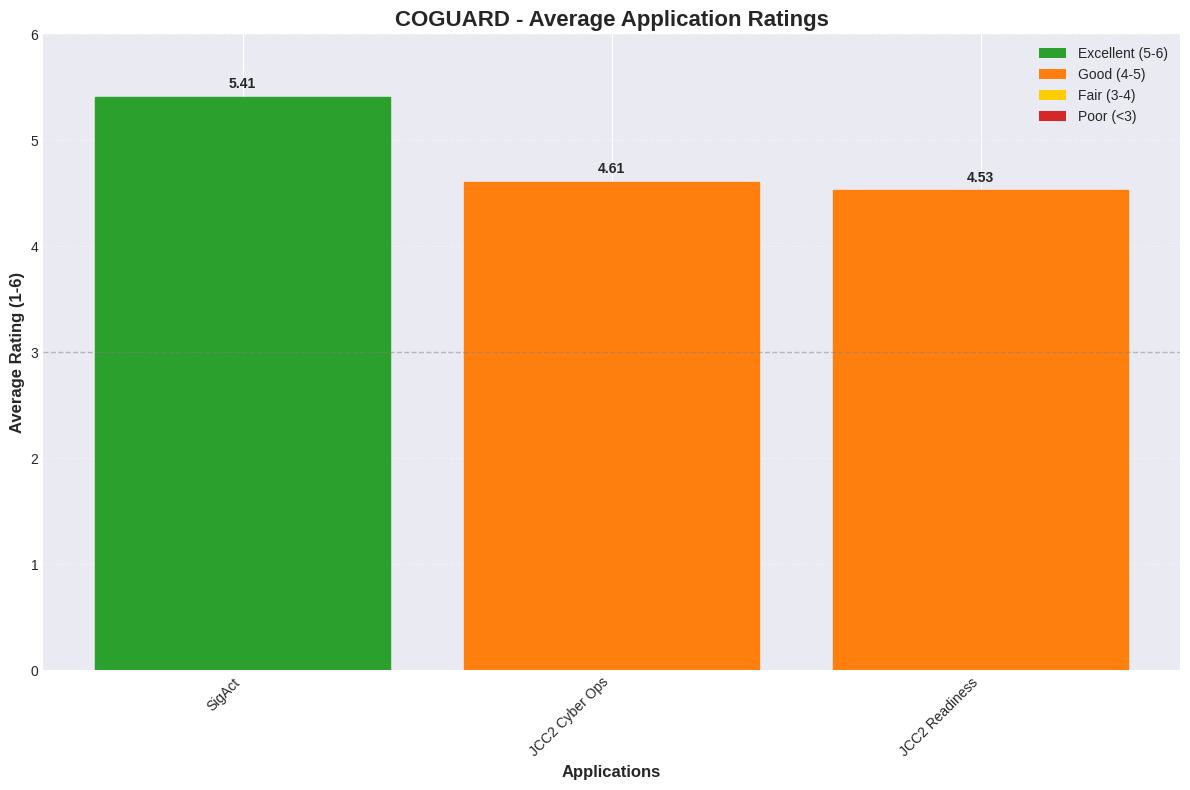


Summary for COGUARD:
  - Total applications with data: 3
  - Highest rated: SigAct (5.41)
  - Lowest rated: JCC2 Readiness (4.53)
  - Average across all apps: 4.85


In [16]:
# Create individual dataset charts for average ratings across all applications
def create_individual_dataset_charts():
    """Create separate bar charts for each dataset showing average ratings for all applications"""
    
    print("\n" + "="*80)
    print("INDIVIDUAL DATASET RATING CHARTS")
    print("="*80)
    
    # Calculate average ratings per application for each dataset
    app_ratings_by_dataset = {}
    
    for dataset_name, data in all_matrix_data.items():
        matrix_data = data['matrix_data']
        row_labels = data['row_labels']
        
        app_ratings = {}
        for i, app in enumerate(row_labels[:-1]):  # Exclude JCC2 Overall
            row = matrix_data[i]
            ratings = []
            for val in row:
                try:
                    rating = float(val)
                    ratings.append(rating)
                except:
                    pass
            
            if ratings:
                app_ratings[app] = np.mean(ratings)
        
        app_ratings_by_dataset[dataset_name] = app_ratings
    
    # Create a figure for each dataset
    for dataset_name, app_ratings in app_ratings_by_dataset.items():
        if not app_ratings:
            continue
            
        # Sort applications by rating (descending)
        sorted_apps = sorted(app_ratings.items(), key=lambda x: x[1], reverse=True)
        apps = [item[0] for item in sorted_apps]
        ratings = [item[1] for item in sorted_apps]
        
        # Create figure
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Create bar chart
        bars = ax.bar(range(len(apps)), ratings, color=COLORS['primary'])
        
        # Color bars based on rating value
        for i, (bar, rating) in enumerate(zip(bars, ratings)):
            bar.set_color(get_rating_styling(float(rating))[0])

        # Customize the plot
        ax.set_xlabel('Applications', fontsize=12, fontweight='bold')
        ax.set_ylabel('Average Rating (1-6)', fontsize=12, fontweight='bold')
        ax.set_title(f'{dataset_name} - Average Application Ratings', fontsize=16, fontweight='bold')
        ax.set_ylim(0, 6)
        
        # Set x-axis labels
        ax.set_xticks(range(len(apps)))
        ax.set_xticklabels(apps, rotation=45, ha='right')
        
        # Add value labels on top of bars
        for i, (app, rating) in enumerate(zip(apps, ratings)):
            ax.text(i, rating + 0.05, f'{rating:.2f}', ha='center', va='bottom', fontweight='bold')
        
        # Add horizontal gridlines for reference
        ax.yaxis.grid(True, linestyle='--', alpha=0.3)
        ax.set_axisbelow(True)
        
        # Add rating scale legend
        legend_elements = get_rating_legend_elements()
        ax.legend(handles=legend_elements, loc='upper right', framealpha=0.9)
        
        # Add horizontal line at rating 3 (midpoint)
        ax.axhline(y=3, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        
        plt.tight_layout()
        
        # Save the figure
        clean_name = dataset_name.replace(' - ', '_').replace(' ', '_').replace('/', '_')
        chart_filename = f"{output_dir}/{clean_name}_average_ratings_chart.png"
        fig.savefig(chart_filename, dpi=300, bbox_inches='tight')
        print(f"\nSaved average ratings chart for {dataset_name} to: {chart_filename}")
        
        # Display the figure
        plt.show()
        plt.close()
        
        # Print summary statistics for this dataset
        print(f"\nSummary for {dataset_name}:")
        print(f"  - Total applications with data: {len(app_ratings)}")
        if ratings:
            print(f"  - Highest rated: {apps[0]} ({ratings[0]:.2f})")
            print(f"  - Lowest rated: {apps[-1]} ({ratings[-1]:.2f})")
            print(f"  - Average across all apps: {np.mean(ratings):.2f}")

# Generate individual dataset charts
create_individual_dataset_charts()

In [17]:
# Generate detailed summary statistics for each dataset
def generate_dataset_statistics(dataset_name, matrix_data, row_labels, column_labels):
    """Generate comprehensive statistics for a single dataset"""
    
    print(f"\n{'='*80}")
    print(f"Summary Statistics for: {dataset_name}")
    print(f"{'='*80}")
    
    # Application statistics
    app_stats = []
    for i, app in enumerate(row_labels[:-1]):  # Exclude JCC2 Overall
        row = matrix_data[i]
        ratings = []
        for val in row:
            try:
                rating = float(val)
                ratings.append(rating)
            except:
                pass
        
        if ratings:
            app_stats.append({
                'Application': app,
                'Avg Rating': np.mean(ratings),
                'Min Rating': min(ratings),
                'Max Rating': max(ratings),
                'Sections Rated': len(ratings),
                'Not Applicable': row.count('x'),
                'No Data': row.count('*'),
                'User NA': row.count('N/A')
            })
    
    app_stats_df = pd.DataFrame(app_stats)
    if not app_stats_df.empty:
        app_stats_df = app_stats_df.sort_values('Avg Rating', ascending=False)
        print("\nApplication Performance Summary:")
        print(app_stats_df.to_string(index=False))
    
    # Section statistics
    section_stats = []
    for j, section in enumerate(column_labels):
        column_values = [matrix_data[i][j] for i in range(len(matrix_data)-1)]  # Exclude JCC2 Overall
        ratings = []
        for val in column_values:
            try:
                rating = float(val)
                ratings.append(rating)
            except:
                pass
        
        if ratings:
            section_stats.append({
                'Section': section,
                'Avg Rating': np.mean(ratings),
                'Min Rating': min(ratings),
                'Max Rating': max(ratings),
                'Apps Rated': len(ratings),
                'Not Applicable': column_values.count('x'),
                'No Data': column_values.count('*'),
                'User NA': column_values.count('N/A')
            })
    
    section_stats_df = pd.DataFrame(section_stats)
    if not section_stats_df.empty:
        section_stats_df = section_stats_df.sort_values('Avg Rating', ascending=False)
        print("\nSection Performance Summary:")
        print(section_stats_df.to_string(index=False))
    
    # Overall statistics
    all_ratings = []
    for row in matrix_data[:-1]:  # Exclude JCC2 Overall
        for val in row:
            try:
                rating = float(val)
                all_ratings.append(rating)
            except:
                pass
    
    if all_ratings:
        print(f"\nOverall Dataset Statistics:")
        print(f"  - Total Ratings: {len(all_ratings)}")
        print(f"  - Average Rating: {np.mean(all_ratings):.2f}")
        print(f"  - Standard Deviation: {np.std(all_ratings):.2f}")
        print(f"  - Minimum Rating: {min(all_ratings):.1f}")
        print(f"  - Maximum Rating: {max(all_ratings):.1f}")
        print(f"  - Median Rating: {np.median(all_ratings):.2f}")
    
    return app_stats_df, section_stats_df

# Generate statistics for all datasets
all_app_stats = {}
all_section_stats = {}

for dataset_name, data in all_matrix_data.items():
    app_stats, section_stats = generate_dataset_statistics(
        dataset_name,
        data['matrix_data'],
        data['row_labels'],
        data['column_labels']
    )
    all_app_stats[dataset_name] = app_stats
    all_section_stats[dataset_name] = section_stats


Summary Statistics for: DCDC

Application Performance Summary:
   Application  Avg Rating  Min Rating  Max Rating  Sections Rated  Not Applicable  No Data  User NA
         Rally    4.245455         2.6         5.5              11              11        0        0
        SigAct    4.063636         2.1         5.0              11              11        0        0
          A2IT    3.788889         3.1         4.6               9              12        0        1
        REDMAP    3.700000         2.0         4.6               9              13        0        0
JCC2 Readiness    3.611111         2.0         4.3               9              13        0        0
  Cyber 9-Line    3.310000         2.0         4.7              10              12        0        0
         MADSS    3.308333         2.2         4.7              12              10        0        0
         Unity    3.233333         2.0         4.5               9              13        0        0
      Dispatch    3.000000 

In [18]:
# Enhanced version with great_tables visualizations
def generate_dataset_statistics_with_tables(dataset_name, matrix_data, row_labels, column_labels):
    """Generate comprehensive statistics for a single dataset with great_tables visualizations"""
    
    # Application statistics
    app_stats = []
    for i, app in enumerate(row_labels[:-1]):  # Exclude JCC2 Overall
        row = matrix_data[i]
        ratings = []
        for val in row:
            try:
                rating = float(val)
                ratings.append(rating)
            except:
                pass
        
        if ratings:
            app_stats.append({
                'Application': app,
                'Avg Rating': np.mean(ratings),
                'Min Rating': min(ratings),
                'Max Rating': max(ratings),
                'Sections Rated': len(ratings),
                'Not Applicable': row.count('x'),
                'No Data': row.count('*'),
                'User NA': row.count('N/A')
            })
    
    app_stats_df = pd.DataFrame(app_stats)
    if not app_stats_df.empty:
        app_stats_df = app_stats_df.sort_values('Avg Rating', ascending=False)
    
    # Section statistics
    section_stats = []
    for j, section in enumerate(column_labels):
        column_values = [matrix_data[i][j] for i in range(len(matrix_data)-1)]  # Exclude JCC2 Overall
        ratings = []
        for val in column_values:
            try:
                rating = float(val)
                ratings.append(rating)
            except:
                pass
        
        if ratings:
            section_stats.append({
                'Section': section,
                'Avg Rating': np.mean(ratings),
                'Min Rating': min(ratings),
                'Max Rating': max(ratings),
                'Apps Rated': len(ratings),
                'Not Applicable': column_values.count('x'),
                'No Data': column_values.count('*'),
                'User NA': column_values.count('N/A')
            })
    
    section_stats_df = pd.DataFrame(section_stats)
    if not section_stats_df.empty:
        section_stats_df = section_stats_df.sort_values('Avg Rating', ascending=False)
    
    # Overall statistics
    all_ratings = []
    for row in matrix_data[:-1]:  # Exclude JCC2 Overall
        for val in row:
            try:
                rating = float(val)
                all_ratings.append(rating)
            except:
                pass
    
    overall_stats = {}
    if all_ratings:
        overall_stats = {
            'Total Ratings': len(all_ratings),
            'Average Rating': np.mean(all_ratings),
            'Std Deviation': np.std(all_ratings),
            'Min Rating': min(all_ratings),
            'Max Rating': max(all_ratings),
            'Median Rating': np.median(all_ratings)
        }
    
    # Create great_tables for application statistics
    app_gt = None
    if not app_stats_df.empty:
        app_gt = (
            GT(app_stats_df)
            .tab_header(
                title=md(f"**{dataset_name} - Application Performance Summary**"),
                subtitle=md("_Sorted by average rating (highest to lowest)_")
            )
            .fmt_number(
                columns=["Avg Rating", "Min Rating", "Max Rating"],
                decimals=2
            )
            .fmt_integer(
                columns=["Sections Rated", "Not Applicable", "No Data", "User NA"]
            )
            # Remove conflicting data_color gradient
            .tab_style(
                style=[style.text(weight="bold"), style.fill(color="#f0f0f0")],
                locations=loc.column_labels()
            )
            .tab_style(
                style=style.text(weight="bold"),
                locations=loc.body(columns=["Application"])
            )
            # Use cleaner conditional coloring for Avg Rating only
            .tab_style(
                style=[style.fill(color=get_rating_styling(5)[0])],  # Green for excellent
                locations=loc.body(
                    columns=["Avg Rating"],
                    rows=lambda df: df["Avg Rating"] >= 5
                )
            )
            .tab_style(
                style=[style.fill(color=get_rating_styling(4)[0])],  # Blue for good
                locations=loc.body(
                    columns=["Avg Rating"],
                    rows=lambda df: (df["Avg Rating"] >= 4) & (df["Avg Rating"] < 5)
                )
            )
            .tab_style(
                style=[style.fill(color=get_rating_styling(3)[0])],  # Yellow for fair
                locations=loc.body(
                    columns=["Avg Rating"],
                    rows=lambda df: (df["Avg Rating"] >= 3) & (df["Avg Rating"] < 4)
                )
            )
            .tab_style(
                style=[style.fill(color=get_rating_styling(2)[0])],  # Red for poor
                locations=loc.body(
                    columns=["Avg Rating"],
                    rows=lambda df: df["Avg Rating"] < 3
                )
            )
            .tab_spanner(
                label=md("**Rating Statistics**"),
                columns=["Avg Rating", "Min Rating", "Max Rating"]
            )
            .tab_spanner(
                label=md("**Coverage**"),
                columns=["Sections Rated", "Not Applicable", "No Data", "User NA"]
            )
            .tab_source_note(
                source_note=md("_Rating scale: 1 = Completely Ineffective, 6 = Completely Effective_")
            )
            .tab_options(
                table_width="900px",
                table_font_size="12px",
                heading_title_font_size="16px",
                heading_subtitle_font_size="12px",
                source_notes_font_size="10px"
            )
        )
    
    # Create great_tables for section statistics
    section_gt = None
    if not section_stats_df.empty:
        section_gt = (
            GT(section_stats_df)
            .tab_header(
                title=md(f"**{dataset_name} - Section Performance Summary**"),
                subtitle=md("_Sorted by average rating (highest to lowest)_")
            )
            .fmt_number(
                columns=["Avg Rating", "Min Rating", "Max Rating"],
                decimals=2
            )
            .fmt_integer(
                columns=["Apps Rated", "Not Applicable", "No Data", "User NA"]
            )
            # Remove conflicting data_color gradient
            .tab_style(
                style=[style.text(weight="bold"), style.fill(color="#f0f0f0")],
                locations=loc.column_labels()
            )
            .tab_style(
                style=style.text(weight="bold"),
                locations=loc.body(columns=["Section"])
            )
            # Use cleaner conditional coloring for Avg Rating only
            .tab_style(
                style=[style.fill(color=get_rating_styling(5)[0])],  # Green for excellent
                locations=loc.body(
                    columns=["Avg Rating"],
                    rows=lambda df: df["Avg Rating"] >= 5
                )
            )
            .tab_style(
                style=[style.fill(color=get_rating_styling(4)[0])],  # Blue for good
                locations=loc.body(
                    columns=["Avg Rating"],
                    rows=lambda df: (df["Avg Rating"] >= 4) & (df["Avg Rating"] < 5)
                )
            )
            .tab_style(
                style=[style.fill(color=get_rating_styling(3)[0])],  # Yellow for fair
                locations=loc.body(
                    columns=["Avg Rating"],
                    rows=lambda df: (df["Avg Rating"] >= 3) & (df["Avg Rating"] < 4)
                )
            )
            .tab_style(
                style=[style.fill(color=get_rating_styling(2)[0])],  # Red for poor
                locations=loc.body(
                    columns=["Avg Rating"],
                    rows=lambda df: df["Avg Rating"] < 3
                )
            )
            .tab_spanner(
                label=md("**Rating Statistics**"),
                columns=["Avg Rating", "Min Rating", "Max Rating"]
            )
            .tab_spanner(
                label=md("**Coverage**"),
                columns=["Apps Rated", "Not Applicable", "No Data", "User NA"]
            )
            .tab_source_note(
                source_note=md("_Rating scale: 1 = Completely Ineffective, 6 = Completely Effective_")
            )
            .tab_options(
                table_width="900px",
                table_font_size="12px",
                heading_title_font_size="16px",
                heading_subtitle_font_size="12px",
                source_notes_font_size="10px"
            )
        )
    
    return app_stats_df, section_stats_df, overall_stats, app_gt, section_gt

In [19]:
# Generate enhanced statistics with great_tables for all datasets
print("\n" + "="*80)
print("ENHANCED DATASET STATISTICS WITH GREAT TABLES")
print("="*80)

all_app_stats_enhanced = {}
all_section_stats_enhanced = {}
all_overall_stats = {}

for dataset_name, data in all_matrix_data.items():
    print(f"\n\nProcessing {dataset_name}...")
    
    app_stats_df, section_stats_df, overall_stats, app_gt, section_gt = generate_dataset_statistics_with_tables(
        dataset_name,
        data['matrix_data'],
        data['row_labels'],
        data['column_labels']
    )
    
    all_app_stats_enhanced[dataset_name] = app_stats_df
    all_section_stats_enhanced[dataset_name] = section_stats_df
    all_overall_stats[dataset_name] = overall_stats
    
    clean_name = dataset_name.replace(' - ', '_').replace(' ', '_').replace('/', '_')
    
    # Display application statistics table
    if app_gt:
        print(f"\nApplication Performance Table for {dataset_name}:")
        display(app_gt)
        
        # Save as PNG
        
        app_table_filename = f"{output_dir}/{clean_name}_application_stats_table.png"
        app_gt.save(app_table_filename, scale=2)
        print(f"Saved to: {app_table_filename}")
    
    # Display section statistics table
    if section_gt:
        print(f"\nSection Performance Table for {dataset_name}:")
        display(section_gt)
        
        # Save as PNG
        section_table_filename = f"{output_dir}/{clean_name}_section_stats_table.png"
        section_gt.save(section_table_filename, scale=2)
        print(f"Saved to: {section_table_filename}")
    
    # Print overall statistics
    if overall_stats:
        print(f"\nOverall Statistics for {dataset_name}:")
        for key, value in overall_stats.items():
            if isinstance(value, float):
                print(f"  - {key}: {value:.2f}")
            else:
                print(f"  - {key}: {value}")


ENHANCED DATASET STATISTICS WITH GREAT TABLES


Processing DCDC...

Application Performance Table for DCDC:


GT(_tbl_data=       Application  Avg Rating  Min Rating  Max Rating  Sections Rated  \
9            Rally    4.245455         2.6         5.5              11   
11          SigAct    4.063636         2.1         5.0              11   
0             A2IT    3.788889         3.1         4.6               9   
10          REDMAP    3.700000         2.0         4.6               9   
7   JCC2 Readiness    3.611111         2.0         4.3               9   
4     Cyber 9-Line    3.310000         2.0         4.7              10   
8            MADSS    3.308333         2.2         4.7              12   
14           Unity    3.233333         2.0         4.5               9   
5         Dispatch    3.000000         1.0         5.0               2   
12      Threat Hub    2.980000         2.1         4.3              10   
2            Codex    2.966667         2.0         4.0               9   
3         Crucible    2.920000         2.0         4.0              10   
13          Triage    2.837500         2.0         4.0               8   
6   JCC2 Cyber Ops    2.563636         1.3         3.8              11   
1              CAD    1.500000         1.0         2.0               2   

    Not Applicable  No Data  User NA  
9               11        0        0  
11              11        0        0  
0               12        0        1  
10              13        0        0  
7               13        0        0  
4               12        0        0  
8               10        0        0  
14              13        0        0  
5               12        0        8  
12              12        0        0  
2               13        0        0  
3               12        0        0  
13              13        0        1  
6               11        0        0  
1               13        0        7  , _body=<great_tables._gt_data.Body object at 0x702a9d6b0990>, _boxhead=Boxhead([ColInfo(var='Application', type=<ColInfoTypeEnum.default: 1>, column_label='Application', column_align='left', column_width=None), ColInfo(var='Avg Rating', type=<ColInfoTypeEnum.default: 1>, column_label='Avg Rating', column_align='right', column_width=None), ColInfo(var='Min Rating', type=<ColInfoTypeEnum.default: 1>, column_label='Min Rating', column_align='right', column_width=None), ColInfo(var='Max Rating', type=<ColInfoTypeEnum.default: 1>, column_label='Max Rating', column_align='right', column_width=None), ColInfo(var='Sections Rated', type=<ColInfoTypeEnum.default: 1>, column_label='Sections Rated', column_align='right', column_width=None), ColInfo(var='Not Applicable', type=<ColInfoTypeEnum.default: 1>, column_label='Not Applicable', column_align='right', column_width=None), ColInfo(var='No Data', type=<ColInfoTypeEnum.default: 1>, column_label='No Data', column_align='right', column_width=None), ColInfo(var='User NA', type=<ColInfoTypeEnum.default: 1>, column_label='User NA', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x702a9d65a690>, _spanners=Spanners([SpannerInfo(spanner_id='**Rating Statistics**', spanner_level=0, spanner_label=Md(text='**Rating Statistics**'), spanner_units=None, spanner_pattern=None, vars=['Avg Rating', 'Min Rating', 'Max Rating'], built=None), SpannerInfo(spanner_id='**Coverage**', spanner_level=0, spanner_label=Md(text='**Coverage**'), spanner_units=None, spanner_pattern=None, vars=['Sections Rated', 'Not Applicable', 'No Data', 'User NA'], built=None)]), _heading=Heading(title=Md(text='**DCDC - Application Performance Summary**'), subtitle=Md(text='_Sorted by average rating (highest to lowest)_'), preheader=None), _stubhead=None, _source_notes=[Md(text='_Rating scale: 1 = Completely Ineffective, 6 = Completely Effective_')], _footnotes=[], _styles=[StyleInfo(locname=LocColumnLabels(columns=None), grpname=None, colname='Application', rownum=None, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, d

Saved to: jcc2_matrix_analysis_output/DCDC_application_stats_table.png

Section Performance Table for DCDC:


GT(_tbl_data=               Section  Avg Rating  Min Rating  Max Rating  Apps Rated  \
9            MOP 1.3.3    4.400000         4.2         4.7           5   
1            MOS 1.1.2    4.375000         3.2         5.0           4   
0            MOP 1.1.1    3.821429         2.5         5.0          14   
11           MOP 2.1.1    3.800000         3.8         3.8           1   
14           MOP 2.4.1    3.800000         3.8         3.8           1   
15           MOS 3.2.1    3.478571         2.0         4.7          14   
4            MOP 1.1.5    3.453846         2.0         4.5          13   
5            MOP 1.2.1    3.422222         2.0         5.5           9   
7            MOS 1.3.1    3.384615         2.4         4.6          13   
16           MOS 3.2.2    3.191667         2.0         4.3          12   
3   Reporting & Export    3.014286         1.0         4.6          14   
2            MOP 1.1.3    3.000000         3.0         3.0           1   
17           MOP 3.2.3    2.971429         1.0         4.5          14   
10           MOP 1.3.4    2.838462         2.1         3.8          13   
13           MOP 2.1.7    2.300000         2.3         2.3           1   
8            MOP 1.3.2    2.200000         2.2         2.2           1   
6            MOP 1.2.2    2.000000         2.0         2.0           1   
12           MOP 2.1.2    1.300000         1.3         1.3           1   

    Not Applicable  No Data  User NA  
9               10        0        0  
1               11        0        0  
0                0        0        1  
11              14        0        0  
14              14        0        0  
15               0        0        1  
4                0        0        2  
5                3        0        3  
7                0        0        2  
16               0        0        3  
3                0        0        1  
2               14        0        0  
17               0        0        1  
10               0        0        2  
13              14        0        0  
8               14        0        0  
6               14        0        0  
12              14        0        0  , _body=<great_tables._gt_data.Body object at 0x702a9df4db10>, _boxhead=Boxhead([ColInfo(var='Section', type=<ColInfoTypeEnum.default: 1>, column_label='Section', column_align='left', column_width=None), ColInfo(var='Avg Rating', type=<ColInfoTypeEnum.default: 1>, column_label='Avg Rating', column_align='right', column_width=None), ColInfo(var='Min Rating', type=<ColInfoTypeEnum.default: 1>, column_label='Min Rating', column_align='right', column_width=None), ColInfo(var='Max Rating', type=<ColInfoTypeEnum.default: 1>, column_label='Max Rating', column_align='right', column_width=None), ColInfo(var='Apps Rated', type=<ColInfoTypeEnum.default: 1>, column_label='Apps Rated', column_align='right', column_width=None), ColInfo(var='Not Applicable', type=<ColInfoTypeEnum.default: 1>, column_label='Not Applicable', column_align='right', column_width=None), ColInfo(var='No Data', type=<ColInfoTypeEnum.default: 1>, column_label='No Data', column_align='right', column_width=None), ColInfo(var='User NA', type=<ColInfoTypeEnum.default: 1>, column_label='User NA', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x702aa02a4f50>, _spanners=Spanners([SpannerInfo(spanner_id='**Rating Statistics**', spanner_level=0, spanner_label=Md(text='**Rating Statistics**'), spanner_units=None, spanner_pattern=None, vars=['Avg Rating', 'Min Rating', 'Max Rating'], built=None), SpannerInfo(spanner_id='**Coverage**', spanner_level=0, spanner_label=Md(text='**Coverage**'), spanner_units=None, spanner_pattern=None, vars=['Apps Rated', 'Not Applicable', 'No Data', 'User NA'], built=None)]), _heading=Heading(title=Md(text='**DCDC - Section Performance Summary**'), subtitle=Md(text='_Sorted by average rating (highest to lowest)_'), preheader=None), _stubhead=None, _source_notes=[Md(text='_Rating scale: 1 =

Saved to: jcc2_matrix_analysis_output/DCDC_section_stats_table.png

Overall Statistics for DCDC:
  - Total Ratings: 132
  - Average Rating: 3.32
  - Std Deviation: 0.94
  - Min Rating: 1.00
  - Max Rating: 5.50
  - Median Rating: 3.35


Processing CNMF...

Application Performance Table for CNMF:


GT(_tbl_data=      Application  Avg Rating  Min Rating  Max Rating  Sections Rated  \
1  JCC2 Readiness    5.128571         4.6         5.5               7   
0  JCC2 Cyber Ops    3.980000         1.0         5.3              10   

   Not Applicable  No Data  User NA  
1              13        0        2  
0              11        0        1  , _body=<great_tables._gt_data.Body object at 0x702a9c371910>, _boxhead=Boxhead([ColInfo(var='Application', type=<ColInfoTypeEnum.default: 1>, column_label='Application', column_align='left', column_width=None), ColInfo(var='Avg Rating', type=<ColInfoTypeEnum.default: 1>, column_label='Avg Rating', column_align='right', column_width=None), ColInfo(var='Min Rating', type=<ColInfoTypeEnum.default: 1>, column_label='Min Rating', column_align='right', column_width=None), ColInfo(var='Max Rating', type=<ColInfoTypeEnum.default: 1>, column_label='Max Rating', column_align='right', column_width=None), ColInfo(var='Sections Rated', type=<ColInfoTypeEnum.default: 1>, column_label='Sections Rated', column_align='right', column_width=None), ColInfo(var='Not Applicable', type=<ColInfoTypeEnum.default: 1>, column_label='Not Applicable', column_align='right', column_width=None), ColInfo(var='No Data', type=<ColInfoTypeEnum.default: 1>, column_label='No Data', column_align='right', column_width=None), ColInfo(var='User NA', type=<ColInfoTypeEnum.default: 1>, column_label='User NA', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x702aa03c2550>, _spanners=Spanners([SpannerInfo(spanner_id='**Rating Statistics**', spanner_level=0, spanner_label=Md(text='**Rating Statistics**'), spanner_units=None, spanner_pattern=None, vars=['Avg Rating', 'Min Rating', 'Max Rating'], built=None), SpannerInfo(spanner_id='**Coverage**', spanner_level=0, spanner_label=Md(text='**Coverage**'), spanner_units=None, spanner_pattern=None, vars=['Sections Rated', 'Not Applicable', 'No Data', 'User NA'], built=None)]), _heading=Heading(title=Md(text='**CNMF - Application Performance Summary**'), subtitle=Md(text='_Sorted by average rating (highest to lowest)_'), preheader=None), _stubhead=None, _source_notes=[Md(text='_Rating scale: 1 = Completely Ineffective, 6 = Completely Effective_')], _footnotes=[], _styles=[StyleInfo(locname=LocColumnLabels(columns=None), grpname=None, colname='Application', rownum=None, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f0f0f0')]), StyleInfo(locname=LocColumnLabels(columns=None), grpname=None, colname='Avg Rating', rownum=None, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f0f0f0')]), StyleInfo(locname=LocColumnLabels(columns=None), grpname=None, colname='Min Rating', rownum=None, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f0f0f0')]), StyleInfo(locname=LocColumnLabels(columns=None), grpname=None, colname='Max Rating', rownum=None, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f0f0f0')]), StyleInfo(locname=LocColumnLabels(columns=None), grpname=None, colname='Sections Rated', rownum=None, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f0f0f0')]), StyleInfo(locname=LocColumnLabels(columns=None), grpname=None, colname='Not Applicable', rownum=None, colnum=None, styles

Saved to: jcc2_matrix_analysis_output/CNMF_application_stats_table.png

Section Performance Table for CNMF:


GT(_tbl_data=               Section  Avg Rating  Min Rating  Max Rating  Apps Rated  \
4            MOP 2.1.1        5.50         5.5         5.5           1   
1            MOP 1.1.5        5.40         5.3         5.5           2   
2            MOS 1.3.1        5.10         5.1         5.1           2   
10           MOP 3.2.3        5.10         5.0         5.2           2   
0   Reporting & Export        4.80         4.6         5.0           2   
8            MOS 3.2.1        4.75         4.5         5.0           2   
9            MOS 3.2.2        4.15         3.3         5.0           2   
5            MOP 2.1.2        4.00         4.0         4.0           1   
7            MOP 2.4.1        3.40         3.4         3.4           1   
3            MOP 1.3.4        3.20         3.2         3.2           1   
6            MOP 2.1.7        1.00         1.0         1.0           1   

    Not Applicable  No Data  User NA  
4               14        0        0  
1                0       13        0  
2                0       13        0  
10               0       13        0  
0                0       13        0  
8                0       13        0  
9                0       13        0  
5               14        0        0  
7               14        0        0  
3                0       13        1  
6               14        0        0  , _body=<great_tables._gt_data.Body object at 0x702a9c345d10>, _boxhead=Boxhead([ColInfo(var='Section', type=<ColInfoTypeEnum.default: 1>, column_label='Section', column_align='left', column_width=None), ColInfo(var='Avg Rating', type=<ColInfoTypeEnum.default: 1>, column_label='Avg Rating', column_align='right', column_width=None), ColInfo(var='Min Rating', type=<ColInfoTypeEnum.default: 1>, column_label='Min Rating', column_align='right', column_width=None), ColInfo(var='Max Rating', type=<ColInfoTypeEnum.default: 1>, column_label='Max Rating', column_align='right', column_width=None), ColInfo(var='Apps Rated', type=<ColInfoTypeEnum.default: 1>, column_label='Apps Rated', column_align='right', column_width=None), ColInfo(var='Not Applicable', type=<ColInfoTypeEnum.default: 1>, column_label='Not Applicable', column_align='right', column_width=None), ColInfo(var='No Data', type=<ColInfoTypeEnum.default: 1>, column_label='No Data', column_align='right', column_width=None), ColInfo(var='User NA', type=<ColInfoTypeEnum.default: 1>, column_label='User NA', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x702a9c347850>, _spanners=Spanners([SpannerInfo(spanner_id='**Rating Statistics**', spanner_level=0, spanner_label=Md(text='**Rating Statistics**'), spanner_units=None, spanner_pattern=None, vars=['Avg Rating', 'Min Rating', 'Max Rating'], built=None), SpannerInfo(spanner_id='**Coverage**', spanner_level=0, spanner_label=Md(text='**Coverage**'), spanner_units=None, spanner_pattern=None, vars=['Apps Rated', 'Not Applicable', 'No Data', 'User NA'], built=None)]), _heading=Heading(title=Md(text='**CNMF - Section Performance Summary**'), subtitle=Md(text='_Sorted by average rating (highest to lowest)_'), preheader=None), _stubhead=None, _source_notes=[Md(text='_Rating scale: 1 = Completely Ineffective, 6 = Completely Effective_')], _footnotes=[], _styles=[StyleInfo(locname=LocColumnLabels(columns=None), grpname=None, colname='Section', rownum=None, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f0f0f0')]), StyleInfo(locname=LocColumnLabels(columns=None), grpname=None, colname='Avg Rating', rownum=None, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f0f0f0')]), StyleInfo(locname=LocColumnLabels(columns=None), grpname=None, colname='Min Ratin

Saved to: jcc2_matrix_analysis_output/CNMF_section_stats_table.png

Overall Statistics for CNMF:
  - Total Ratings: 17
  - Average Rating: 4.45
  - Std Deviation: 1.13
  - Min Rating: 1.00
  - Max Rating: 5.50
  - Median Rating: 5.00


Processing COGUARD...

Application Performance Table for COGUARD:


GT(_tbl_data=      Application  Avg Rating  Min Rating  Max Rating  Sections Rated  \
2          SigAct    5.411111         5.0         6.0               9   
0  JCC2 Cyber Ops    4.611111         1.0         5.5               9   
1  JCC2 Readiness    4.533333         3.0         5.3               6   

   Not Applicable  No Data  User NA  
2              11        0        2  
0              11        0        2  
1              13        0        3  , _body=<great_tables._gt_data.Body object at 0x702a9c46f9d0>, _boxhead=Boxhead([ColInfo(var='Application', type=<ColInfoTypeEnum.default: 1>, column_label='Application', column_align='left', column_width=None), ColInfo(var='Avg Rating', type=<ColInfoTypeEnum.default: 1>, column_label='Avg Rating', column_align='right', column_width=None), ColInfo(var='Min Rating', type=<ColInfoTypeEnum.default: 1>, column_label='Min Rating', column_align='right', column_width=None), ColInfo(var='Max Rating', type=<ColInfoTypeEnum.default: 1>, column_label='Max Rating', column_align='right', column_width=None), ColInfo(var='Sections Rated', type=<ColInfoTypeEnum.default: 1>, column_label='Sections Rated', column_align='right', column_width=None), ColInfo(var='Not Applicable', type=<ColInfoTypeEnum.default: 1>, column_label='Not Applicable', column_align='right', column_width=None), ColInfo(var='No Data', type=<ColInfoTypeEnum.default: 1>, column_label='No Data', column_align='right', column_width=None), ColInfo(var='User NA', type=<ColInfoTypeEnum.default: 1>, column_label='User NA', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x702a9c4841d0>, _spanners=Spanners([SpannerInfo(spanner_id='**Rating Statistics**', spanner_level=0, spanner_label=Md(text='**Rating Statistics**'), spanner_units=None, spanner_pattern=None, vars=['Avg Rating', 'Min Rating', 'Max Rating'], built=None), SpannerInfo(spanner_id='**Coverage**', spanner_level=0, spanner_label=Md(text='**Coverage**'), spanner_units=None, spanner_pattern=None, vars=['Sections Rated', 'Not Applicable', 'No Data', 'User NA'], built=None)]), _heading=Heading(title=Md(text='**COGUARD - Application Performance Summary**'), subtitle=Md(text='_Sorted by average rating (highest to lowest)_'), preheader=None), _stubhead=None, _source_notes=[Md(text='_Rating scale: 1 = Completely Ineffective, 6 = Completely Effective_')], _footnotes=[], _styles=[StyleInfo(locname=LocColumnLabels(columns=None), grpname=None, colname='Application', rownum=None, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f0f0f0')]), StyleInfo(locname=LocColumnLabels(columns=None), grpname=None, colname='Avg Rating', rownum=None, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f0f0f0')]), StyleInfo(locname=LocColumnLabels(columns=None), grpname=None, colname='Min Rating', rownum=None, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f0f0f0')]), StyleInfo(locname=LocColumnLabels(columns=None), grpname=None, colname='Max Rating', rownum=None, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f0f0f0')]), StyleInfo(locname=LocColumnLabels(columns=None), grpname=None, colname='Sections Rated', rownum=None, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f0f0f0')]), StyleIn

Saved to: jcc2_matrix_analysis_output/COGUARD_application_stats_table.png

Section Performance Table for COGUARD:


GT(_tbl_data=               Section  Avg Rating  Min Rating  Max Rating  Apps Rated  \
0            MOS 1.1.2    6.000000         6.0         6.0           1   
2            MOP 1.1.5    5.750000         5.5         6.0           2   
8            MOP 2.4.1    5.500000         5.5         5.5           1   
4            MOP 1.3.3    5.300000         5.3         5.3           1   
6            MOP 2.1.1    5.300000         5.3         5.3           1   
3            MOS 1.3.1    5.066667         4.9         5.4           3   
5            MOP 1.3.4    5.050000         4.9         5.2           2   
1   Reporting & Export    5.033333         5.0         5.1           3   
9            MOS 3.2.1    5.000000         5.0         5.0           3   
11           MOP 3.2.3    4.633333         3.0         5.7           3   
10           MOS 3.2.2    4.500000         4.0         5.0           3   
7            MOP 2.1.7    1.000000         1.0         1.0           1   

    Not Applicable  No Data  User NA  
0               11        2        1  
2                0       11        2  
8               14        0        0  
4               10        3        1  
6               14        0        0  
3                0       11        1  
5                0       11        2  
1                0       11        1  
9                0       11        1  
11               0       11        1  
10               0       11        1  
7               14        0        0  , _body=<great_tables._gt_data.Body object at 0x702a9c4721d0>, _boxhead=Boxhead([ColInfo(var='Section', type=<ColInfoTypeEnum.default: 1>, column_label='Section', column_align='left', column_width=None), ColInfo(var='Avg Rating', type=<ColInfoTypeEnum.default: 1>, column_label='Avg Rating', column_align='right', column_width=None), ColInfo(var='Min Rating', type=<ColInfoTypeEnum.default: 1>, column_label='Min Rating', column_align='right', column_width=None), ColInfo(var='Max Rating', type=<ColInfoTypeEnum.default: 1>, column_label='Max Rating', column_align='right', column_width=None), ColInfo(var='Apps Rated', type=<ColInfoTypeEnum.default: 1>, column_label='Apps Rated', column_align='right', column_width=None), ColInfo(var='Not Applicable', type=<ColInfoTypeEnum.default: 1>, column_label='Not Applicable', column_align='right', column_width=None), ColInfo(var='No Data', type=<ColInfoTypeEnum.default: 1>, column_label='No Data', column_align='right', column_width=None), ColInfo(var='User NA', type=<ColInfoTypeEnum.default: 1>, column_label='User NA', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x702a9d6cb990>, _spanners=Spanners([SpannerInfo(spanner_id='**Rating Statistics**', spanner_level=0, spanner_label=Md(text='**Rating Statistics**'), spanner_units=None, spanner_pattern=None, vars=['Avg Rating', 'Min Rating', 'Max Rating'], built=None), SpannerInfo(spanner_id='**Coverage**', spanner_level=0, spanner_label=Md(text='**Coverage**'), spanner_units=None, spanner_pattern=None, vars=['Apps Rated', 'Not Applicable', 'No Data', 'User NA'], built=None)]), _heading=Heading(title=Md(text='**COGUARD - Section Performance Summary**'), subtitle=Md(text='_Sorted by average rating (highest to lowest)_'), preheader=None), _stubhead=None, _source_notes=[Md(text='_Rating scale: 1 = Completely Ineffective, 6 = Completely Effective_')], _footnotes=[], _styles=[StyleInfo(locname=LocColumnLabels(columns=None), grpname=None, colname='Section', rownum=None, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f0f0f0')]), StyleInfo(locname=LocColumnLabels(columns=None), grpname=None, colname='Avg Rating', rownum=None, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None),

Saved to: jcc2_matrix_analysis_output/COGUARD_section_stats_table.png

Overall Statistics for COGUARD:
  - Total Ratings: 24
  - Average Rating: 4.89
  - Std Deviation: 1.01
  - Min Rating: 1.00
  - Max Rating: 6.00
  - Median Rating: 5.00


In [20]:
# Create overall dataset summary great_table
def create_overall_summary_table(all_overall_stats):
    """Create a comprehensive summary table comparing all datasets"""
    
    summary_data = []
    
    for dataset_name, stats in all_overall_stats.items():
        if stats:
            summary_data.append({
                'Dataset': dataset_name,
                'Total Ratings': stats.get('Total Ratings', 0),
                'Average Rating': stats.get('Average Rating', 0),
                'Std Deviation': stats.get('Std Deviation', 0),
                'Min Rating': stats.get('Min Rating', 0),
                'Max Rating': stats.get('Max Rating', 0),
                'Median Rating': stats.get('Median Rating', 0)
            })
    
    summary_df = pd.DataFrame(summary_data)
    
    if not summary_df.empty:
        summary_gt = (
            GT(summary_df)
            .tab_header(
                title=md("**Overall Dataset Comparison**"),
                subtitle=md("_Comprehensive rating statistics across all datasets_")
            )
            .fmt_integer(
                columns=["Total Ratings"]
            )
            .fmt_number(
                columns=["Average Rating", "Std Deviation", "Min Rating", "Max Rating", "Median Rating"],
                decimals=2
            )
            .data_color(
                columns=["Average Rating"],
                domain=[1, 6],
                na_color="#e0e0e0"
            )
            .tab_style(
                style=[style.text(weight="bold"), style.fill(color="#f0f0f0")],
                locations=loc.column_labels()
            )
            .tab_style(
                style=style.text(weight="bold"),
                locations=loc.body(columns=["Dataset"])
            )
            .tab_style(
                style=[style.fill(color=get_rating_styling(5)[0])],
                locations=loc.body(
                    columns=["Average Rating"],
                    rows=lambda df: df["Average Rating"] >= 5
                )
            )
            .tab_style(
                style=[style.fill(color=get_rating_styling(4)[0])],
                locations=loc.body(
                    columns=["Average Rating"],
                    rows=lambda df: df["Average Rating"] >= 4 & (df["Average Rating"] < 5)
                )
            )
            .tab_style(
                style=[style.fill(color=get_rating_styling(3)[0])],
                locations=loc.body(
                    columns=["Average Rating"],
                    rows=lambda df: (df["Average Rating"] >= 3) & (df["Average Rating"] < 4)
                )
            )
            .tab_style(
                style=[style.fill(color=get_rating_styling(2)[0])],
                locations=loc.body(
                    columns=["Average Rating"],
                    rows=lambda df: df["Average Rating"] < 3
                )
            )
            .tab_spanner(
                label=md("**Central Tendency**"),
                columns=["Average Rating", "Median Rating"]
            )
            .tab_spanner(
                label=md("**Variability**"),
                columns=["Std Deviation", "Min Rating", "Max Rating"]
            )
            .tab_source_note(
                source_note=md("_All ratings on a 1-6 scale where 1 = Completely Ineffective and 6 = Completely Effective_")
            )
            .tab_options(
                table_width="900px",
                table_font_size="12px",
                heading_title_font_size="16px",
                heading_subtitle_font_size="12px",
                source_notes_font_size="10px"
            )
        )
        
        return summary_gt
    
    return None

# Create and display the overall summary table
print("\n" + "="*80)
print("OVERALL DATASET COMPARISON")
print("="*80)

summary_gt = create_overall_summary_table(all_overall_stats)
if summary_gt:
    display(summary_gt)
    
    # Save as PNG
    summary_filename = f"{output_dir}/overall_dataset_comparison_table.png"
    summary_gt.save(summary_filename, scale=2)
    print(f"\nSaved overall comparison table to: {summary_filename}")
else:
    print("No data available for overall summary table")


OVERALL DATASET COMPARISON


GT(_tbl_data=   Dataset  Total Ratings  Average Rating  Std Deviation  Min Rating  \
0     DCDC            132        3.324242       0.936557         1.0   
1     CNMF             17        4.452941       1.128830         1.0   
2  COGUARD             24        4.891667       1.008678         1.0   

   Max Rating  Median Rating  
0         5.5           3.35  
1         5.5           5.00  
2         6.0           5.00  , _body=<great_tables._gt_data.Body object at 0x702a9c48b310>, _boxhead=Boxhead([ColInfo(var='Dataset', type=<ColInfoTypeEnum.default: 1>, column_label='Dataset', column_align='left', column_width=None), ColInfo(var='Total Ratings', type=<ColInfoTypeEnum.default: 1>, column_label='Total Ratings', column_align='right', column_width=None), ColInfo(var='Average Rating', type=<ColInfoTypeEnum.default: 1>, column_label='Average Rating', column_align='right', column_width=None), ColInfo(var='Median Rating', type=<ColInfoTypeEnum.default: 1>, column_label='Median Rating', column_align='right', column_width=None), ColInfo(var='Std Deviation', type=<ColInfoTypeEnum.default: 1>, column_label='Std Deviation', column_align='right', column_width=None), ColInfo(var='Min Rating', type=<ColInfoTypeEnum.default: 1>, column_label='Min Rating', column_align='right', column_width=None), ColInfo(var='Max Rating', type=<ColInfoTypeEnum.default: 1>, column_label='Max Rating', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x702a9c43d010>, _spanners=Spanners([SpannerInfo(spanner_id='**Central Tendency**', spanner_level=0, spanner_label=Md(text='**Central Tendency**'), spanner_units=None, spanner_pattern=None, vars=['Average Rating', 'Median Rating'], built=None), SpannerInfo(spanner_id='**Variability**', spanner_level=0, spanner_label=Md(text='**Variability**'), spanner_units=None, spanner_pattern=None, vars=['Std Deviation', 'Min Rating', 'Max Rating'], built=None)]), _heading=Heading(title=Md(text='**Overall Dataset Comparison**'), subtitle=Md(text='_Comprehensive rating statistics across all datasets_'), preheader=None), _stubhead=None, _source_notes=[Md(text='_All ratings on a 1-6 scale where 1 = Completely Ineffective and 6 = Completely Effective_')], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='Average Rating', rows=[0], mask=None), grpname=None, colname='Average Rating', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#24aae6')]), StyleInfo(locname=LocBody(columns='Average Rating', rows=[1], mask=None), grpname=None, colname='Average Rating', rownum=1, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#b22fc3')]), StyleInfo(locname=LocBody(columns='Average Rating', rows=[2], mask=None), grpname=None, colname='Average Rating', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#df5f6f')]), StyleInfo(locname=LocColumnLabels(columns=None), grpname=None, colname='Dataset', rownum=None, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f0f0f0')]), StyleInfo(locname=LocColumnLabels(columns=None), grpname=None, colname='Total Ratings', rownum=None, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f0f0f0')]), StyleInfo(locname=LocColumnLabels(columns=None), grpname=None, colname='Ave


Saved overall comparison table to: jcc2_matrix_analysis_output/overall_dataset_comparison_table.png


# Detailed statistics generation

# Enhanced Statistics with Great Tables

The following cells create professional, publication-ready tables using the great_tables library for presenting dataset statistics. These tables include:

1. **Application Performance Tables**: Shows average, min, and max ratings for each application, along with coverage statistics
2. **Section Performance Tables**: Shows average, min, and max ratings for each section, along with the number of applications rated
3. **Overall Dataset Comparison**: A summary table comparing key statistics across all datasets

All tables are color-coded based on ratings:
- Green: Excellent performance (5-6)
- Orange: Good performance (4-5)
- Yellow: Fair performance (3-4) 
- Red: Poor performance (<3)

Tables are automatically saved as PNG images for use in presentations and reports.

In [21]:
# Create summary tables using great_tables
def create_summary_great_table(app_comparison_df, section_comparison_df):
    """Create summary tables showing top performers across datasets"""

    # Top Applications Table
    top_apps = app_comparison_df.mean(axis=1).nlargest(10).round(2)
    top_apps_df = pd.DataFrame(
        {
            "Application": top_apps.index,
            "Average Rating": top_apps.values,
            "Rating Category": [get_rating_styling(r)[1] for r in top_apps.values]
        }
    )

    app_gt = (
        GT(top_apps_df)
        .tab_header(
            title=md("**Top 10 Performing Applications**"),
            subtitle=md("_Average ratings across all datasets_"),
        )
        # .data_color(
        #     columns=["Average Rating"],
        #     palette=["#ff6666", "#ffcc00", "#ffff00", "#ccff00", "#66ff66"],
        #     domain=[1, 6],
        # )
        .fmt_number(columns=["Average Rating"], decimals=2)
        .tab_style(
            style=[style.text(weight="bold"), style.fill(color="#f0f0f0")],
            locations=loc.column_labels(),
        )
        .tab_style(
            style=[style.fill(color=get_rating_styling(5)[0])],
            locations=loc.body(
                columns=["Average Rating"], rows=lambda df: df["Average Rating"] >= 5
            ),
        )
        .tab_style(
            style=[style.fill(color=get_rating_styling(4)[0])],
            locations=loc.body(
                columns=["Average Rating"],
                rows=lambda df: df["Average Rating"] >= 4 & (df["Average Rating"] < 5),
            ),
        )
        .tab_style(
            style=[style.fill(color=get_rating_styling(3)[0])],
            locations=loc.body(
                columns=["Average Rating"],
                rows=lambda df: (df["Average Rating"] >= 3)
                & (df["Average Rating"] < 4),
            ),
        )
        .tab_style(
            style=[style.fill(color=get_rating_styling(2)[0])],
            locations=loc.body(
                columns=["Average Rating"], rows=lambda df: df["Average Rating"] < 3
            ),
        )
        .tab_options(
            table_width="600px",
            table_font_size="12px",
            heading_title_font_size="16px",
            heading_subtitle_font_size="12px",
        )
    )

    # Top Sections Table
    top_sections = section_comparison_df.mean(axis=1).nlargest(10).round(2)
    top_sections_df = pd.DataFrame(
        {
            "Section": top_sections.index,
            "Average Rating": top_sections.values,
            "Rating Category": [get_rating_styling(r)[1] for r in top_sections.values],
        }
    )

    section_gt = (
        GT(top_sections_df)
        .tab_header(
            title=md("**Top 10 Performing Sections**"),
            subtitle=md("_Average ratings across all datasets_"),
        )
        # .data_color(
        #     columns=["Average Rating"],
        #     palette=["#ff6666", "#ffcc00", "#ffff00", "#ccff00", "#66ff66"],
        #     domain=[1, 6],
        # )
        .fmt_number(columns=["Average Rating"], decimals=2)
        .tab_style(
            style=[style.text(weight="bold"), style.fill(color="#f0f0f0")],
            locations=loc.column_labels(),
        )
        .tab_style(
            style=[style.fill(color=get_rating_styling(5)[0])],
            locations=loc.body(
                columns=["Average Rating"], rows=lambda df: df["Average Rating"] >= 5
            ),
        )
        .tab_style(
            style=[style.fill(color=get_rating_styling(4)[0])],
            locations=loc.body(
                columns=["Average Rating"],
                rows=lambda df: df["Average Rating"] >= 4 & (df["Average Rating"] < 5),
            ),
        )
        .tab_style(
            style=[style.fill(color=get_rating_styling(3)[0])],
            locations=loc.body(
                columns=["Average Rating"],
                rows=lambda df: (df["Average Rating"] >= 3)
                & (df["Average Rating"] < 4),
            ),
        )
        .tab_style(
            style=[style.fill(color=get_rating_styling(2)[0])],
            locations=loc.body(
                columns=["Average Rating"], rows=lambda df: df["Average Rating"] < 3
            ),
        )
        .tab_options(
            table_width="600px",
            table_font_size="12px",
            heading_title_font_size="16px",
            heading_subtitle_font_size="12px",
        )
    )

    return app_gt, section_gt


# Create and display summary tables
print("\n" + "=" * 80)
print("SUMMARY GREAT TABLES")
print("=" * 80)

app_summary_gt, section_summary_gt = create_summary_great_table(
    app_comparison_df, section_comparison_df
)

print("\nTop Applications Summary:")
display(app_summary_gt)
app_summary_gt.save(f"{output_dir}/top_applications_summary.png")
print(f"Saved to: {output_dir}/top_applications_summary.png")

print("\nTop Sections Summary:")
display(section_summary_gt)
section_summary_gt.save(f"{output_dir}/top_sections_summary.png")
print(f"Saved to: {output_dir}/top_sections_summary.png")


SUMMARY GREAT TABLES

Top Applications Summary:


GT(_tbl_data=      Application  Average Rating Rating Category
0  JCC2 Readiness            4.42      Good (4-5)
1  JCC2 Cyber Ops            3.72      Fair (3-4)
2          SigAct            3.16      Fair (3-4)
3           Rally            1.42       Poor (<3)
4            A2IT            1.26       Poor (<3)
5          REDMAP            1.23       Poor (<3)
6    Cyber 9-Line            1.10       Poor (<3)
7           MADSS            1.10       Poor (<3)
8           Unity            1.08       Poor (<3)
9        Dispatch            1.00       Poor (<3), _body=<great_tables._gt_data.Body object at 0x702a9c2f5010>, _boxhead=Boxhead([ColInfo(var='Application', type=<ColInfoTypeEnum.default: 1>, column_label='Application', column_align='left', column_width=None), ColInfo(var='Average Rating', type=<ColInfoTypeEnum.default: 1>, column_label='Average Rating', column_align='right', column_width=None), ColInfo(var='Rating Category', type=<ColInfoTypeEnum.default: 1>, column_label='Rating Category', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x702a9c2f7450>, _spanners=Spanners([]), _heading=Heading(title=Md(text='**Top 10 Performing Applications**'), subtitle=Md(text='_Average ratings across all datasets_'), preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocColumnLabels(columns=None), grpname=None, colname='Application', rownum=None, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f0f0f0')]), StyleInfo(locname=LocColumnLabels(columns=None), grpname=None, colname='Average Rating', rownum=None, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f0f0f0')]), StyleInfo(locname=LocColumnLabels(columns=None), grpname=None, colname='Rating Category', rownum=None, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f0f0f0')]), StyleInfo(locname=LocBody(columns=['Average Rating'], rows=<function create_summary_great_table.<locals>.<lambda> at 0x702a9c468b80>, mask=None), grpname=None, colname='Average Rating', rownum=0, colnum=None, styles=[CellStyleFill(color='#ff7f0e')]), StyleInfo(locname=LocBody(columns=['Average Rating'], rows=<function create_summary_great_table.<locals>.<lambda> at 0x702a9c468b80>, mask=None), grpname=None, colname='Average Rating', rownum=1, colnum=None, styles=[CellStyleFill(color='#ff7f0e')]), StyleInfo(locname=LocBody(columns=['Average Rating'], rows=<function create_summary_great_table.<locals>.<lambda> at 0x702a9c468b80>, mask=None), grpname=None, colname='Average Rating', rownum=2, colnum=None, styles=[CellStyleFill(color='#ff7f0e')]), StyleInfo(locname=LocBody(columns=['Average Rating'], rows=<function create_summary_great_table.<locals>.<lambda> at 0x702a9c468b80>, mask=None), grpname=None, colname='Average Rating', rownum=3, colnum=None, styles=[CellStyleFill(color='#ff7f0e')]), StyleInfo(locname=LocBody(columns=['Average Rating'], rows=<function create_summary_great_table.<locals>.<lambda> at 0x702a9c468b80>, mask=None), grpname=None, colname='Average Rating', rownum=4, colnum=None, styles=[CellStyleFill(color='#ff7f0e')]), StyleInfo(locname=LocBody(columns=['Average Rating'], rows=<function create_summary_great_table.<locals>.<lambda> at 0x702a9c468b80>, mask=None), grpname=None, colname='Average Rating', rownum=5, colnum=None, styles=[CellStyleFill(color='#ff7f0e')]), StyleInfo(locname=LocBody(columns=['Average Rating'], rows=<function create_summary_great_table.<locals>.<lambda> at 0x702a9c468b80>, mask=None), grpname=None, colname='Average Rating', rownu

Saved to: jcc2_matrix_analysis_output/top_applications_summary.png

Top Sections Summary:


GT(_tbl_data=              Section  Average Rating Rating Category
0           MOP 1.1.5            4.87      Good (4-5)
1           MOP 2.1.1            4.87      Good (4-5)
2           MOS 1.3.1            4.52      Good (4-5)
3           MOS 3.2.1            4.41      Good (4-5)
4  Reporting & Export            4.28      Good (4-5)
5           MOP 3.2.3            4.23      Good (4-5)
6           MOP 2.4.1            4.23      Good (4-5)
7           MOS 3.2.2            3.95      Fair (3-4)
8           MOP 1.3.4            3.70      Fair (3-4)
9           MOS 1.1.2            3.46      Fair (3-4), _body=<great_tables._gt_data.Body object at 0x702a9c37ae90>, _boxhead=Boxhead([ColInfo(var='Section', type=<ColInfoTypeEnum.default: 1>, column_label='Section', column_align='left', column_width=None), ColInfo(var='Average Rating', type=<ColInfoTypeEnum.default: 1>, column_label='Average Rating', column_align='right', column_width=None), ColInfo(var='Rating Category', type=<ColInfoTypeEnum.default: 1>, column_label='Rating Category', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x702a9c379cd0>, _spanners=Spanners([]), _heading=Heading(title=Md(text='**Top 10 Performing Sections**'), subtitle=Md(text='_Average ratings across all datasets_'), preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocColumnLabels(columns=None), grpname=None, colname='Section', rownum=None, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f0f0f0')]), StyleInfo(locname=LocColumnLabels(columns=None), grpname=None, colname='Average Rating', rownum=None, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f0f0f0')]), StyleInfo(locname=LocColumnLabels(columns=None), grpname=None, colname='Rating Category', rownum=None, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f0f0f0')]), StyleInfo(locname=LocBody(columns=['Average Rating'], rows=<function create_summary_great_table.<locals>.<lambda> at 0x702a9c32c2c0>, mask=None), grpname=None, colname='Average Rating', rownum=0, colnum=None, styles=[CellStyleFill(color='#ff7f0e')]), StyleInfo(locname=LocBody(columns=['Average Rating'], rows=<function create_summary_great_table.<locals>.<lambda> at 0x702a9c32c2c0>, mask=None), grpname=None, colname='Average Rating', rownum=1, colnum=None, styles=[CellStyleFill(color='#ff7f0e')]), StyleInfo(locname=LocBody(columns=['Average Rating'], rows=<function create_summary_great_table.<locals>.<lambda> at 0x702a9c32c2c0>, mask=None), grpname=None, colname='Average Rating', rownum=2, colnum=None, styles=[CellStyleFill(color='#ff7f0e')]), StyleInfo(locname=LocBody(columns=['Average Rating'], rows=<function create_summary_great_table.<locals>.<lambda> at 0x702a9c32c2c0>, mask=None), grpname=None, colname='Average Rating', rownum=3, colnum=None, styles=[CellStyleFill(color='#ff7f0e')]), StyleInfo(locname=LocBody(columns=['Average Rating'], rows=<function create_summary_great_table.<locals>.<lambda> at 0x702a9c32c2c0>, mask=None), grpname=None, colname='Average Rating', rownum=4, colnum=None, styles=[CellStyleFill(color='#ff7f0e')]), StyleInfo(locname=LocBody(columns=['Average Rating'], rows=<function create_summary_great_table.<locals>.<lambda> at 0x702a9c32c2c0>, mask=None), grpname=None, colname='Average Rating', rownum=5, colnum=None, styles=[CellStyleFill(color='#ff7f0e')]), StyleInfo(locname=LocBody(columns=['Average Rating'], rows=<function create_summary_great_table.<locals>.<lambda> at 0x702a9c32c2c0>, mask=None), grpname=None, col

Saved to: jcc2_matrix_analysis_output/top_sections_summary.png


In [22]:
# Export all results to files
import os
from datetime import datetime

# Create output directory
output_dir = 'jcc2_matrix_analysis_output'
os.makedirs(output_dir, exist_ok=True)

# Create timestamp for filenames
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Export individual matrices
for dataset_name, matrix_df in all_matrices.items():
    # Clean filename
    clean_name = dataset_name.replace(' - ', '_').replace(' ', '_').replace('/', '_')
    
    # Export matrix
    matrix_filename = f"{output_dir}/{clean_name}_matrix_{timestamp}.csv"
    matrix_df.to_csv(matrix_filename)
    print(f"Exported matrix for {dataset_name} to: {matrix_filename}")
    
    # Export detailed report
    detailed_report = []
    data = all_matrix_data[dataset_name]
    matrix_data = data['matrix_data']
    row_labels = data['row_labels']
    column_labels = data['column_labels']
    
    for i, app in enumerate(row_labels):
        for j, section in enumerate(column_labels):
            value = matrix_data[i][j]
            detailed_report.append({
                'Application': app,
                'Section': section,
                'Rating': value,
                'Status': 'Not Applicable' if value == 'x' else 
                         'No Data' if value == '*' else 
                         'User NA' if value == 'N/A' else 'Rated'
            })
    
    detailed_df = pd.DataFrame(detailed_report)
    detailed_filename = f"{output_dir}/{clean_name}_detailed_{timestamp}.csv"
    detailed_df.to_csv(detailed_filename, index=False)
    print(f"Exported detailed report for {dataset_name} to: {detailed_filename}")

# Export comparative analysis
comparison_filename = f"{output_dir}/comparative_analysis_{timestamp}.xlsx"
with pd.ExcelWriter(comparison_filename, engine='openpyxl') as writer:
    # Application comparison
    app_comparison_df.to_excel(writer, sheet_name='Application_Comparison')
    
    # Section comparison
    section_comparison_df.to_excel(writer, sheet_name='Section_Comparison')
    
    # Overall statistics
    stats_df.to_excel(writer, sheet_name='Overall_Statistics')
    
    # Response counts
    response_counts_df = pd.DataFrame({
        'Dataset': list(dataframes.keys()),
        'Response_Count': [len(df) for df in dataframes.values()]
    })
    response_counts_df.to_excel(writer, sheet_name='Response_Counts', index=False)

print(f"\nExported comparative analysis to: {comparison_filename}")

# Create summary report
summary_report = f"""
JCC2 Application-Section Matrix Analysis Report
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

DATASETS ANALYZED:
"""

for dataset_name, df in dataframes.items():
    summary_report += f"\n- {dataset_name}: {len(df)} responses"

summary_report += f"\n\nOUTPUT FILES GENERATED:"
summary_report += f"\n- Individual matrix files: {len(all_matrices)} files"
summary_report += f"\n- Individual detailed reports: {len(all_matrices)} files"
summary_report += f"\n- Comparative analysis: {comparison_filename}"

summary_report += "\n\nTOP PERFORMING APPLICATIONS (Average across all datasets):"
top_apps = app_comparison_df.mean(axis=1).nlargest(5)
for app, rating in top_apps.items():
    summary_report += f"\n- {app}: {rating:.2f}"

summary_report += "\n\nTOP PERFORMING SECTIONS (Average across all datasets):"
top_sections = section_comparison_df.mean(axis=1).nlargest(5)
for section, rating in top_sections.items():
    summary_report += f"\n- {section}: {rating:.2f}"

# Save summary report
summary_filename = f"{output_dir}/analysis_summary_{timestamp}.txt"
with open(summary_filename, 'w') as f:
    f.write(summary_report)

print(f"\nSaved summary report to: {summary_filename}")
print("\nAll exports completed successfully!")

Exported matrix for DCDC to: jcc2_matrix_analysis_output/DCDC_matrix_20250804_075524.csv
Exported detailed report for DCDC to: jcc2_matrix_analysis_output/DCDC_detailed_20250804_075524.csv
Exported matrix for CNMF to: jcc2_matrix_analysis_output/CNMF_matrix_20250804_075524.csv
Exported detailed report for CNMF to: jcc2_matrix_analysis_output/CNMF_detailed_20250804_075524.csv
Exported matrix for COGUARD to: jcc2_matrix_analysis_output/COGUARD_matrix_20250804_075524.csv
Exported detailed report for COGUARD to: jcc2_matrix_analysis_output/COGUARD_detailed_20250804_075524.csv

Exported comparative analysis to: jcc2_matrix_analysis_output/comparative_analysis_20250804_075524.xlsx

Saved summary report to: jcc2_matrix_analysis_output/analysis_summary_20250804_075524.txt

All exports completed successfully!


# Export results to files

In [23]:
# Create detailed statistics table using great_tables
def create_dataset_stats_great_table(stats_df, response_counts):
    """Create a comprehensive statistics table for all datasets"""

    # Prepare data
    stats_enhanced = stats_df.copy()
    stats_enhanced["Response Count"] = [
        response_counts[idx] for idx in stats_enhanced.index
    ]
    stats_enhanced = stats_enhanced.reset_index()
    stats_enhanced.columns = [
        "Dataset",
        "Mean Rating",
        "Std Dev",
        "Min Rating",
        "Max Rating",
        "Response Count",
    ]

    # Create great_table
    stats_gt = (
        GT(stats_enhanced)
        .tab_header(
            title=md("**Dataset Statistics Overview**"),
            subtitle=md(
                "_Comprehensive rating statistics across all questionnaire datasets_"
            ),
        )
        .fmt_number(
            columns=["Mean Rating", "Std Dev", "Min Rating", "Max Rating"], decimals=2
        )
        .fmt_integer(columns=["Response Count"])
        # .data_color(
        #     columns=["Mean Rating"],
        #     palette=["#ff6666", "#ffcc00", "#ffff00", "#ccff00", "#66ff66"],
        #     domain=[1, 6]
        # )
        .tab_style(
            style=[style.text(weight="bold"), style.fill(color="#f0f0f0")],
            locations=loc.column_labels(),
        )
        .tab_style(
            style=style.text(weight="bold"), locations=loc.body(columns=["Dataset"])
        )
        .tab_style(
            style=[style.fill(color=get_rating_styling(5)[0])],
            locations=loc.body(
                columns=["Mean Rating"], rows=lambda df: df["Mean Rating"] >= 5
            ),
        )
        .tab_style(
            style=[style.fill(color=get_rating_styling(4)[0])],
            locations=loc.body(
                columns=["Mean Rating"],
                rows=lambda df: df["Mean Rating"] >= 4 & (df["Mean Rating"] < 5),
            ),
        )
        .tab_style(
            style=[style.fill(color=get_rating_styling(3)[0])],
            locations=loc.body(
                columns=["Mean Rating"],
                rows=lambda df: (df["Mean Rating"] >= 3)
                & (df["Mean Rating"] < 4),
            ),
        )
        .tab_style(
            style=[style.fill(color=get_rating_styling(2)[0])],
            locations=loc.body(
                columns=["Mean Rating"], rows=lambda df: df["Mean Rating"] < 3
            ),
        )
        .tab_spanner(
            label=md("**Rating Statistics**"),
            columns=["Mean Rating", "Std Dev", "Min Rating", "Max Rating"],
        )
        .tab_source_note(
            source_note=md(
                "_All ratings are on a 1-6 scale where 1 = Completely Ineffective and 6 = Completely Effective_"
            )
        )
        .tab_options(
            table_width="800px",
            table_font_size="12px",
            heading_title_font_size="16px",
            heading_subtitle_font_size="12px",
            source_notes_font_size="10px",
        )
    )

    return stats_gt


# Create and display dataset statistics table
print("\n" + "=" * 80)
print("DATASET STATISTICS GREAT TABLE")
print("=" * 80)

# Get response counts
response_counts = {name: len(df) for name, df in dataframes.items()}

dataset_stats_gt = create_dataset_stats_great_table(stats_df, response_counts)
display(dataset_stats_gt)
dataset_stats_filename = f"{output_dir}/dataset_statistics_summary.png"
dataset_stats_gt.save(dataset_stats_filename)
print(f"\nSaved dataset statistics table to: {dataset_stats_filename}")


DATASET STATISTICS GREAT TABLE


GT(_tbl_data=   Dataset  Mean Rating   Std Dev  Min Rating  Max Rating  Response Count
0     DCDC     3.324242  0.936557         1.0         5.5              21
1     CNMF     4.452941  1.128830         1.0         5.5               6
2  COGUARD     4.891667  1.008678         1.0         6.0               6, _body=<great_tables._gt_data.Body object at 0x702a9d5eee90>, _boxhead=Boxhead([ColInfo(var='Dataset', type=<ColInfoTypeEnum.default: 1>, column_label='Dataset', column_align='left', column_width=None), ColInfo(var='Mean Rating', type=<ColInfoTypeEnum.default: 1>, column_label='Mean Rating', column_align='right', column_width=None), ColInfo(var='Std Dev', type=<ColInfoTypeEnum.default: 1>, column_label='Std Dev', column_align='right', column_width=None), ColInfo(var='Min Rating', type=<ColInfoTypeEnum.default: 1>, column_label='Min Rating', column_align='right', column_width=None), ColInfo(var='Max Rating', type=<ColInfoTypeEnum.default: 1>, column_label='Max Rating', column_align='right', column_width=None), ColInfo(var='Response Count', type=<ColInfoTypeEnum.default: 1>, column_label='Response Count', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x702a97e74c50>, _spanners=Spanners([SpannerInfo(spanner_id='**Rating Statistics**', spanner_level=0, spanner_label=Md(text='**Rating Statistics**'), spanner_units=None, spanner_pattern=None, vars=['Mean Rating', 'Std Dev', 'Min Rating', 'Max Rating'], built=None)]), _heading=Heading(title=Md(text='**Dataset Statistics Overview**'), subtitle=Md(text='_Comprehensive rating statistics across all questionnaire datasets_'), preheader=None), _stubhead=None, _source_notes=[Md(text='_All ratings are on a 1-6 scale where 1 = Completely Ineffective and 6 = Completely Effective_')], _footnotes=[], _styles=[StyleInfo(locname=LocColumnLabels(columns=None), grpname=None, colname='Dataset', rownum=None, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f0f0f0')]), StyleInfo(locname=LocColumnLabels(columns=None), grpname=None, colname='Mean Rating', rownum=None, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f0f0f0')]), StyleInfo(locname=LocColumnLabels(columns=None), grpname=None, colname='Std Dev', rownum=None, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f0f0f0')]), StyleInfo(locname=LocColumnLabels(columns=None), grpname=None, colname='Min Rating', rownum=None, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f0f0f0')]), StyleInfo(locname=LocColumnLabels(columns=None), grpname=None, colname='Max Rating', rownum=None, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f0f0f0')]), StyleInfo(locname=LocColumnLabels(columns=None), grpname=None, colname='Response Count', rownum=None, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f0f0f0')]), StyleInfo(locname=LocBody(columns=['Dataset'], rows=None, mask=None), grpname=None, colname='Dataset', rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style=None, weight='bold', stretch=None, decorate=None, transform=None, whi


Saved dataset statistics table to: jcc2_matrix_analysis_output/dataset_statistics_summary.png


## Summary

This notebook generates comprehensive matrices showing the relationship between JCC2 applications and evaluation sections across multiple datasets. 

### Key Features:
1. **Multi-Dataset Analysis**: Processes multiple questionnaire datasets simultaneously
2. **Application-Section Matrices**: Shows ratings for each application in each section
3. **Visual Heatmaps**: Color-coded visualization of ratings across applications and sections
4. **Great Tables Integration**: Professional table formatting with the great_tables package
5. **Comparative Analysis**: Cross-dataset comparisons to identify trends and patterns
6. **Statistical Summaries**: Detailed performance metrics for applications and sections
7. **Data Export**: Comprehensive export functionality for further analysis

### Output:
- Individual rating matrices for each dataset
- Visual heatmaps with clear rating scales
- Professional great_tables HTML outputs with interactive styling
- Comparative analysis charts across datasets
- Detailed CSV and Excel exports with all results
- Summary statistics and performance metrics

### Great Tables Features:
- Color-coded cells based on rating values (red to green gradient)
- Professional formatting with headers, subtitles, and source notes
- Responsive HTML tables for easy sharing and presentation
- Summary tables highlighting top performers
- Dataset statistics overview with comprehensive metrics